# The bidirectional role of DTA mutational burden on MDS survival

# Basic packages

In [1]:
import numpy as np
import pandas as pd
#import i2bmi

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)

# Overall survival (OS)

# Data Loading and Preprocessing

## Load pre-processed data

In [3]:
### Path definitions

from pathlib import Path

# Folder where this script lives 
HERE = Path.cwd()

# Project root -> go one level up from HERE
PROJECT_ROOT = HERE.parent

# Get paths to the data output folders
OUTPUT = PROJECT_ROOT / "output"
FIGURES = PROJECT_ROOT / "figures"

In [4]:
### Load data using saved csv file (created based on data pre-processing script)
df=pd.read_csv(OUTPUT / "mds_dta_cohort_os.csv")  

In [5]:
df.head()

,os_months,os_status,age,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,asxl1_only_counts,dta_non_asxl1_counts,asxl1_mixed_counts,sex_Male,sex_nan,mds_type_primary,mds_type_s_t_MDS,mds_type_nan,complex_karyotype_non-complex,complex_karyotype_nan,flt3_itd_TRUE,flt3_itd_nan,mll_ptd_TRUE,mll_ptd_nan,dta_group_asxl1_only,dta_group_no_dta,dta_group_non_asxl1,dta_group_nan,age_nan,bm_blast_nan,pb_blast_nan,hbg_nan,plt_nan,wbc_nan,anc_nan,monocytes_nan
0,23.868493,0,87.0,1.0,0.0,7.5,80.0,3.38,2.80,0.50,13.05,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,2,2,0,0,0,0.0,2.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,7.134247,1,91.0,1.0,0.0,7.7,203.0,9.70,4.75,0.72,13.05,0,1,0,0.0,1.0,0.0,1.0,1.0,1,0,1,0,1,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,13.117808,0,55.0,14.5,0.0,8.8,31.0,3.60,2.40,0.10,15.22,0,0,1,0.0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,49.742466,0,78.0,6.0,0.0,14.0,125.0,3.30,0.89,0.20,17.40,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,1,1,0,0,0,0.0,2.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,18.805479,0,88.0,1.0,0.0,8.6,139.0,5.90,4.40,NaN,6.52,0,1,0,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [6]:
### Split data in features and outcomes (X and y)
target_cols = ['os_months', 'os_status']
X = df.drop(columns=target_cols)
y = df[['os_months', 'os_status']]

# Splitting Data into Training and Testing Sets

The most important step to avoid Data Leakage, carried out using the `train_test_split` function from the `sklearn.model_selection` module.

In [7]:
### Split training and testing sets
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y['os_status']) #to ensure fair distribution of events

In [8]:
len(X_train), len(X_test)

(2520, 630)

# Standardization/ Data Scaler (z-score)

It centers features to mean 0 and standard deviation as 1. Since most ML algorithms assume approx normal distribution, scaling is used to improve performance, particularly in classification models. \
Once training data is established, we pursued scaling using `StandardScaler`.
Scaling was performed before imputation since we are using MICE, which can be affected by magnitude of variables

In [9]:
### Initialize the Scaler and chose columns to scale (only float64 columns need to normalize and few extra ones, do not normalize dummies even if "numerical")
from sklearn.preprocessing import StandardScaler

# Fit the scaler *only* on the training data
scaler = StandardScaler()
cols_to_scale = X.select_dtypes(include=['float64']).columns.tolist()
extra_cols = ['asxl1_only_counts', 'dta_non_asxl1_counts', 'asxl1_mixed_counts', 'dta_non_asxl1_counts', 'truncating_variant', 'asxl1_truncating_variant', 'dnmt3a_truncating_variant', 'tet2_truncating_variant', 'n_truncating_variant', 'pathogenic_asxl1', 'pathogenic_dnmt3a', 'pathogenic_tet2']

all_cols_to_scale = cols_to_scale + extra_cols

# Fit on all columns
scaler.fit(X_train[all_cols_to_scale])

# Transform all columns
X_train[all_cols_to_scale] = scaler.transform(X_train[all_cols_to_scale])
X_test[all_cols_to_scale] = scaler.transform(X_test[all_cols_to_scale]) #trained on train, applied to test

In [10]:
X_train.head()

,age,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,asxl1_only_counts,dta_non_asxl1_counts,asxl1_mixed_counts,sex_Male,sex_nan,mds_type_primary,mds_type_s_t_MDS,mds_type_nan,complex_karyotype_non-complex,complex_karyotype_nan,flt3_itd_TRUE,flt3_itd_nan,mll_ptd_TRUE,mll_ptd_nan,dta_group_asxl1_only,dta_group_no_dta,dta_group_non_asxl1,dta_group_nan,age_nan,bm_blast_nan,pb_blast_nan,hbg_nan,plt_nan,wbc_nan,anc_nan,monocytes_nan
1306,0.602790,-0.661811,-0.227685,-0.432922,-0.846266,0.920021,1.253171,-0.393478,1.185219,1,0,1,1.375819,-0.417604,1.647031,1.838846,1.730548,0.981130,1.461245,-0.269194,2.137838,2.427718,2.021017,-0.264999,-0.229384,-0.420024,-0.596042,2.985542,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2039,-0.236931,1.759988,-0.227685,0.018056,0.065002,-0.358422,-0.447336,-0.351367,-0.617912,0,0,0,-0.582974,-0.417604,-0.605625,-0.943715,-1.079363,-1.019233,-0.572072,-0.269194,-0.542437,-0.822999,-0.460934,-0.264999,-0.229384,-0.420024,-0.596042,-0.345435,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1338,-1.580485,0.856722,0.000772,1.086677,-0.159513,-0.333164,-0.342130,-0.368211,-0.256623,0,1,0,-0.582974,1.875125,-0.605625,-0.016195,0.325593,-1.019233,-0.572072,-0.269194,-0.542437,-0.822999,-0.460934,-0.264999,-0.229384,-0.420024,0.515746,-0.345435,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
684,0.686762,0.516361,-0.227685,-0.481942,-0.172720,-0.446825,-0.554455,-0.347155,-0.977544,0,0,1,-0.582974,-0.417604,0.520703,-0.016195,0.325593,-1.019233,-0.572072,-0.269194,-0.542437,-0.822999,-0.460934,-0.264999,-0.229384,-0.420024,0.515746,-0.345435,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
895,-0.236931,0.123637,NaN,0.057271,-1.070781,-0.148586,-0.047554,NaN,-0.977544,1,0,0,1.375819,-0.417604,-0.605625,-0.016195,0.325593,0.981130,1.461245,-0.269194,-0.542437,0.260573,-0.460934,-0.264999,-0.229384,2.047248,-0.596042,-0.345435,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


# Imputation

The dataset has missing values (NaN). To manage this (and since the data has been already split to avoid data leakage):
1. CADD and phyloP (MOST LIKELY) will have missing values if truncating_variant = 1 since they are novel frameshifts not reported in databases (ClinVar and gnomAD). 
2. That said, we will performed imputation using MICE appproach and Random Forest Regressor as the estimator. 
3. Finally, the very fist step was add missingness indicators for every predictor with `NaN` (already done).

In [11]:
### MICE imputation for remaining missing values (Train set only)


from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Identifying columns with missing values (tolist)
cols_with_missing = X_train.columns[X_train.isnull().any()].tolist()

# Use all columns as predictors
predictor_cols = X_train.columns.tolist()

# Initialize MICE imputer with Random Forest as estimator
mice_imputer = IterativeImputer(
    random_state=42,
    max_iter=10,
    estimator=RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    sample_posterior=False
)

# Fit MICE imputer on training data (it will return as array)
data_imputed_array_train = mice_imputer.fit_transform(X_train[predictor_cols])

# Convert array back to DataFrame (full imputed train matrix)
X_train_imputed_full = pd.DataFrame(
    data_imputed_array_train,
    columns=predictor_cols,
    index=X_train.index
)

# Overwrite ONLY columns that had missing values
X_train[cols_with_missing] = X_train_imputed_full[cols_with_missing]

/Users/hernandez.p/miniforge3/envs/pydev/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [12]:
### MICE imputation for testing set

# Apply MICE imputer on testing data (using training-fitted imputer)
data_imputed_array_test = mice_imputer.transform(X_test[predictor_cols])

# Convert output array back to DataFrame (full imputed test matrix)
X_test_imputed = pd.DataFrame(
    data_imputed_array_test,
    columns=predictor_cols,
    index=X_test.index
)

# Overwrite ONLY columns that had missing values
X_test[cols_with_missing] = X_test_imputed[cols_with_missing]

# Machine Learning Models
Considering we are evaluating survival anlaysis as outcomes, we searched for related models. 
1. **CoxPH** is a traditional statistical analysis that struggles with high-dimensional data and multicollinearity. However `CoxnetSurvivalAnalysis` is a machine learning model that predicts survival in high-dimensional data settings. It is less vulnerable to overfitting due to Elastic Net (L1 and L2) penalties (PMID: 37884606, 27065756)

2. **Random Survival Forest** is a nonparametric machine learning model that handles non-linear interactions. Other similar studies have used this model (see abstract)

3. **Gradient-Boosted Survival Trees**: "A gradient boosted model is similar to a Random Survival Forest, in the sense that it relies on multiple base learners to produce an overall prediction, but differs in how those are combined. While a Random Survival Forest fits a set of Survival Trees independently and then averages their predictions, a gradient boosted model is constructed sequentially in a greedy stagewise fashion." (scikit-survival)


# Hyperparameter tuning

Hyperparameter tuning (or optimization) is the process of finding the best set of hyperparameter values that maximize model performance (e.g., accuracy, AUC, F1, etc.) on validation data.

### Note: 
We have experienced issue with censoring (time_train.max), since every time point that is passed must lie in a region where the censoring Kaplan-Meier (under the hood analysis) is defined (i.e., up to the last censoring time in the training set) AND must have follow-up in the test set (i.e., between the minimun and maximum observed test times). U;timately this was caused by `integrated_brier_score`. We fixed having the IBS evaluation to always construct a safe time grid from the durrent data instead of hard-coding percentiles.

In [13]:
### Prepare IBS evaluation function and time grid

import numpy as np

def prepare_ibs_evaluation(y_train_surv, y_test_surv, X_test, n_grid=200, eps=1e-3):
    """
    Prepare a test subset and time grid that are valid for integrated_brier_score.

    IBS restriction:
      - Only test patients with follow-up < max(train time) are used.
      - Time grid is chosen within the overlap of train times and IBS-eligible test times.
    """
    time_train = y_train_surv["os_months"]
    time_test_all = y_test_surv["os_months"]

    # Max observed time in TRAIN (this is what sksurv's censoring KM uses)
    max_train_time = time_train.max()

    # Keep only test patients with follow-up strictly below max_train_time
    ibs_mask = time_test_all < max_train_time
    n_ibs = ibs_mask.sum()
    if n_ibs < 2:
        raise ValueError(f"Too few IBS-eligible test patients: {n_ibs}.")

    # Structured array subset for Surv
    y_test_surv_ibs = y_test_surv[ibs_mask]

    # Match X_test rows
    if hasattr(X_test, "iloc"):
        idx = np.where(ibs_mask)[0]
        X_test_ibs = X_test.iloc[idx]
    else:
        X_test_ibs = X_test[ibs_mask]

    # Build a time grid in the overlap between train and IBS-eligible test
    time_test_ibs = y_test_surv_ibs["os_months"]

    t_min = max(time_train.min(), time_test_ibs.min())
    t_max = min(max_train_time, time_test_ibs.max()) - eps  # stay strictly below max_train_time

    if t_max <= t_min:
        raise ValueError(f"Invalid IBS time window: t_min={t_min}, t_max={t_max}")

    time_grid = np.linspace(t_min, t_max, n_grid, endpoint=False)

    return X_test_ibs, y_test_surv_ibs, time_grid, max_train_time


### CoxNetSurvival
We are doing simple `GridSearch` as there are only two parameters (alpha and L1 regularization). That said, it is feasible to search for all possibilities/combinations \
To evaluate performance, we are using Harrell's C-index and Integrated Brier Score (IBS), 

References: 
1. Haider H., Hoehn B eet al. Effective  Ways to Build and Evaluate Individual Survival Distributions. Journal of Machine Learning Research 21 (2020) 1-63 
2. Ping Wang, Yan Li, and Chandan k. Reddy. 2019. Machine Learning for Survival Analysis: A Survey. ACM
Comput. Surv. 51, 6, Article 110 (February 2019)
3. https://scikit-survival.readthedocs.io/en/latest/user_guide/evaluating-survival-models.html



### Note:
In the earlier analysis, all patients with zero survival duration were randomly assigned to the test set only, so `CoxnetSurvivalAnalysis` never encountered a non-positive time in model fitting. \
After feature engineering and column removal, the train/test distribution changed, placing some zero-time patients in the training folds. \
`CoxnetSurvivalAnalysis` requires strictly positive survival times and will crash (segfault) when encountering zero values during partial likelihood computation. \
Adjusting the time origin by adding a small constant (e.g., 0.01 months) prevents this issue without affecting hazard ratios or model discrimination.

In [14]:
### Avoid zero months by clipping at small value and avoid kernel crashes

epsilon = 0.01

y_train["os_months"] = y_train["os_months"].clip(lower=epsilon)
y_test["os_months"]  = y_test["os_months"].clip(lower=epsilon)


### Note:
Some correlated features remained even after dropping fold-constant ones.
`CoxnetSurvivalAnalysis` is extremely sensitive to correlation (weights blow up at small alpha and small tol (1e−7))

So the solution was: increase regularization + relax the solver tolerance

The `sksurv` authors explicitly recommend:
- alpha_min ≥ 0.01 for medium-sized datasets
- tol ≥ 1e−6
- max_iter ≤ 2000

In [15]:
### Coxnet model with hyperparameter tuning, C-index and IBS evaluation

from sklearn.model_selection import KFold, GridSearchCV
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
import numpy as np
import time

# Custom scoring function - C-index for GridSearchCV
def cindex_scorer(estimator, X, y_struct):
    pred = estimator.predict(X)
    return concordance_index_censored(
        y_struct["os_status"], y_struct["os_months"], pred
    )[0]

# Model
cox = CoxnetSurvivalAnalysis(
    fit_baseline_model=True,  # needed for predict_survival_function
    max_iter=20000, #max iterations or steps for convergence
    tol=1e-6  # tolerance for convergence (min change in coefficients)
)

# Parameter grid
alpha_path = np.logspace(-2, 1, 50)
param_grid_coxnet = {
    "alphas": [alpha_path], #intensity of regularization
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9], #balance between L1 and L2 regularization
}

# Cross-validation setup (in the training set)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search setup
grid_search_coxnet = GridSearchCV(
    estimator=cox,
    param_grid=param_grid_coxnet,
    cv=cv,
    scoring=cindex_scorer,
    n_jobs=1,
    refit=True,
    verbose=1,
    error_score="raise"
)

## Prepare survival data for training and test
y_train = y_train.copy()
y_train["os_status"] = y_train["os_status"].fillna(0).astype(int).astype(bool)

y_test = y_test.copy()
y_test["os_status"] = y_test["os_status"].fillna(0).astype(int).astype(bool)

y_train_surv = Surv.from_dataframe("os_status", "os_months", y_train)
y_test_surv  = Surv.from_dataframe("os_status", "os_months", y_test)

# Fit model
grid_search_coxnet.fit(X_train, y_train_surv)

print("Best params:", grid_search_coxnet.best_params_)
print(f"Best C-index on train (CV): {grid_search_coxnet.best_score_:.4f}")

cox_best = grid_search_coxnet.best_estimator_


## Test metrics – C-index

pred_test = cox_best.predict(X_test)
c_index_test = concordance_index_censored(
    y_test_surv["os_status"],
    y_test_surv["os_months"],
    pred_test
)[0]
print(f"C-index on test set (full): {c_index_test:.4f}")

### IBS on IBS-eligible subset (subsampled, with safe grid)

#epsilon = 1e-3  # small margin so times are strictly inside follow-up

# IBS-eligible subset using helper
X_test_cox_ibs, y_test_surv_ibs_cox, TIME_GRID_COX, max_train_time_cox = prepare_ibs_evaluation(
    y_train_surv, y_test_surv, X_test, n_grid=100   # 100 time points is enough
)

print(f"Max train time (Cox): {max_train_time_cox:.2f}")
print(f"Max test time (all): {y_test_surv['os_months'].max():.2f}")
print(f"Max IBS-eligible test time (Cox): {y_test_surv_ibs_cox['os_months'].max():.2f}")
print(f"TIME_GRID_COX range (pre-subsample): {TIME_GRID_COX.min():.2f} to {TIME_GRID_COX.max():.2f}")
print(f"IBS-eligible test size (before subsampling): {len(y_test_surv_ibs_cox)}")

# Subsample IBS test set for speed
max_ibs_test = 300
n_ibs_cox = len(y_test_surv_ibs_cox)

if n_ibs_cox > max_ibs_test:
    rng = np.random.default_rng(42)
    idx_sub_cox = rng.choice(n_ibs_cox, size=max_ibs_test, replace=False)

    if hasattr(X_test_cox_ibs, "iloc"):
        X_test_cox_ibs_sub = X_test_cox_ibs.iloc[idx_sub_cox]
    else:
        X_test_cox_ibs_sub = X_test_cox_ibs[idx_sub_cox]

    y_test_surv_ibs_sub_cox = y_test_surv_ibs_cox[idx_sub_cox]
    print(f"Subsampled IBS test size (Cox): {len(y_test_surv_ibs_sub_cox)} (from {n_ibs_cox})")
else:
    X_test_cox_ibs_sub = X_test_cox_ibs
    y_test_surv_ibs_sub_cox = y_test_surv_ibs_cox

# Recompute a VALID time grid for this subsample
time_train = y_train_surv["os_months"]
time_test_sub_cox = y_test_surv_ibs_sub_cox["os_months"]

t_min = max(time_train.min(), time_test_sub_cox.min())
t_max = min(time_train.max(), time_test_sub_cox.max()) - epsilon  # strictly < max(test_time)

if t_max <= t_min:
    raise ValueError(f"Invalid IBS time window after subsample (Cox): t_min={t_min}, t_max={t_max}")

n_grid = 100
TIME_GRID_COX_SUB = np.linspace(t_min, t_max, n_grid, endpoint=False)

print(f"TIME_GRID_COX_SUB range: {TIME_GRID_COX_SUB.min():.2f} to {TIME_GRID_COX_SUB.max():.2f}")
print(f"Cox subsample follow-up range: {time_test_sub_cox.min():.2f} to {time_test_sub_cox.max():.2f}")

# Predict survival functions on the subsample
t0 = time.time()
surv_fns_cox = list(cox_best.predict_survival_function(X_test_cox_ibs_sub))
print(f"Cox predict_survival_function done in {time.time() - t0:.2f} s")

# Evaluate survival on the new grid
t1 = time.time()
surv_probs_cox = np.asarray([fn(TIME_GRID_COX_SUB) for fn in surv_fns_cox])
print(f"Building surv_probs_cox done in {time.time() - t1:.2f} s")
print("surv_probs_cox shape:", surv_probs_cox.shape)

# IBS
t2 = time.time()
ibs_test = integrated_brier_score(
    y_train_surv,
    y_test_surv_ibs_sub_cox,
    surv_probs_cox,
    TIME_GRID_COX_SUB
)
print(f"integrated_brier_score (Cox) done in {time.time() - t2:.2f} s")

print(f"IBS on test set (IBS-eligible subset, subsampled): {ibs_test:.4f}")

results = {"c_index_test": c_index_test, "ibs_test": ibs_test}


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'alphas': array([ 0.01      ,  0.01151395,  0.01325711,  0.01526418,  0.01757511,
        0.0202359 ,  0.02329952,  0.02682696,  0.03088844,  0.0355648 ,
        0.04094915,  0.04714866,  0.05428675,  0.06250552,  0.07196857,
        0.08286428,  0.09540955,  0.10985411,  0.12648552,  0.14563485,
        0.16768329,  0.19306977,  0.22229965,  0.25595479,  0.29470517,
        0.33932218,  0.39069399,  0.44984327,  0.51794747,  0.59636233,
        0.68664885,  0.79060432,  0.91029818,  1.04811313,  1.20679264,
        1.38949549,  1.59985872,  1.84206997,  2.12095089,  2.44205309,
        2.8117687 ,  3.23745754,  3.72759372,  4.29193426,  4.94171336,
        5.68986603,  6.55128557,  7.54312006,  8.68511374, 10.        ]), 'l1_ratio': 0.1}
Best C-index on train (CV): 0.7232
C-index on test set (full): 0.7406
Max train time (Cox): 208.50
Max test time (all): 264.53
Max IBS-eligible test time (Cox): 205.78
TIME_GRID

## Bootstrap CoxSurvival

We decided to run bootstrap to be consistent with similar studies and provide uncertainty in the C-index score. \
Boostrap: will pick `n_test` (nomber of row of test set) 1,000 times (B = 1,000). Some may be repeat, some may not appear since it is with replacement. Then, it will compute C-index and IBS for each iteration. From this, we will get percentiles 2.5 - 97.5

In [16]:
### Bootstrap C-index (CoxNet)

from sksurv.metrics import concordance_index_censored
import numpy as np


# Point estimate on full test set
time_test  = y_test_surv["os_months"]
event_test = y_test_surv["os_status"].astype(bool)

risk_test = cox_best.predict(X_test)

cindex_test_cox = concordance_index_censored(
    event_test,
    time_test,
    risk_test
)[0]

print(f"C-index (test, CoxNet) point estimate: {cindex_test_cox:.4f}")


# Bootstrap 95% CI on full test set
rng = np.random.default_rng(123)
B = 1000

n_test = X_test.shape[0]
cindex_boot_cox = np.empty(B, dtype=float)

print(f"Bootstrap C-index on full test set ({n_test} patients) – CoxNet.")

for b in range(B):
    idx = rng.integers(0, n_test, size=n_test)

    Xb = X_test.iloc[idx]
    tb = time_test[idx]
    eb = event_test[idx]

    risk_b = cox_best.predict(Xb)

    cindex_b = concordance_index_censored(
        eb,
        tb,
        risk_b
    )[0]

    cindex_boot_cox[b] = cindex_b

cindex_ci_cox = np.percentile(cindex_boot_cox, [2.5, 97.5])

print(
    f"C-index (test, CoxNet): {cindex_test_cox:.4f} | "
    f"95% CI [{cindex_ci_cox[0]:.4f}, {cindex_ci_cox[1]:.4f}]"
)


C-index (test, CoxNet) point estimate: 0.7406
Bootstrap C-index on full test set (630 patients) – CoxNet.
C-index (test, CoxNet): 0.7406 | 95% CI [0.7138, 0.7686]


In [17]:
### Bootstrap IBS on subsampled IBS-eligible set (Cox) --- no C-index in this code

# Bootstrap setup
rng = np.random.default_rng(123)  # reproducible bootstrap
B = 1000                          # number of bootstrap resamples

ibs_boot = []

time_train  = y_train_surv["os_months"]
event_train = y_train_surv["os_status"]

censor_times = time_train[~event_train]
if censor_times.size == 0:
    raise ValueError("Cannot compute IBS/bootstrap: no censored observations in training data.")
max_train_time = time_train.max()
eps = 1e-3

n_ibs = X_test_cox_ibs_sub.shape[0]
print(f"Bootstrap IBS on {n_ibs} subsampled IBS-eligible test patients (Cox).")

for _ in range(B):
    # Resample within subsampled IBS set
    idx_ibs = rng.integers(0, n_ibs, size=n_ibs)

    Xb_ibs = X_test_cox_ibs_sub.iloc[idx_ibs]
    yb_surv = y_test_surv_ibs_sub_cox[idx_ibs]
    yb_event = yb_surv["os_status"]
    yb_time  = yb_surv["os_months"]

    # Safe time window for this bootstrap replicate
    t_min_b = max(time_train.min(), yb_time.min())
    t_max_b = min(max_train_time, yb_time.max()) - eps

    if t_max_b <= t_min_b:
        continue

    time_points_b = np.linspace(t_min_b, t_max_b, 100, endpoint=False)

    surv_fns_b = list(cox_best.predict_survival_function(Xb_ibs))
    surv_probs_b = np.asarray([fn(time_points_b) for fn in surv_fns_b])


# C-index


    ibs_b = integrated_brier_score(
        y_train_surv,
        yb_surv,
        surv_probs_b,
        time_points_b
    )
    ibs_boot.append(ibs_b)

ibs_boot = np.array(ibs_boot)
ibs_ci = np.percentile(ibs_boot, [2.5, 97.5])

print(f"IBS     (test, subsampled IBS subset): {ibs_test:.4f} | 95% CI [{ibs_ci[0]:.3f}, {ibs_ci[1]:.3f}]")


Bootstrap IBS on 300 subsampled IBS-eligible test patients (Cox).
IBS     (test, subsampled IBS subset): 0.1331 | 95% CI [0.107, 0.180]


# Random Survival Forest
We are implementing hyperparameter tuning by Bayesian optimization (Optuna) since this model will analyze high dimensional and nonlinear relationships, which is exhaustive using `GridSearch` and Random Search may leave the best parameter setiting out. Bayesian approach uses past results to model the parameter-performance relationship and pick the next promising set. Bayesian optimization builds a surrogate models that learns a mapping. Each trial is not random, as this approach chooses the next parameter set based on where it expects the biggest improvement

### Key features of `optuna`
1. **Objective function**: The core of Optuna is the objective function, which encapsulates the model training and evaluation process. This function takes a trial object as an argument, allowing hyperparameter values for the current trial.
2. **Trial Object**: The trial object within the objective function provides methods like `suggest_float()`, `suggest_int()`, `suggest_categorical(`), etc., to define the search space for different types of hyperparameters.
3. **Study**: A `Study` object in Optuna manages the optimization process. You create a study, specify the optimization direction (maximize or minimize the objective function's return value), and then call `study.optimize()` with your objective function and the number of trials.
4. **Pruners**: `optuna` includes pruners that can stop unpromising trials early based on intermediate evaluation scores, saving computational resources.
5. **Samplers**: `optuna` offers various samplers, such as Tree-structured Parzen Estimator (TPE) and Random Search, to intelligently explore the hyperparameter space. TPE, for instance, adapts its search strategy based on the performance of previous trials, focusing on more promising regions. The Tree-structured Parzen Estimator (TPE) is a widely used Bayesian optimization algorithm, and Optuna's default sampler, for efficiently finding the optimal hyperparameters of a machine learning model. TPE intelligently learns from the results of past trials to propose more promising hyperparameters for the next evaluation, significantly outperforming random or grid search methods, especially for complex or computationally expensive problems
6. **Visualization**: `optuna` provides tools for visualizing the optimization process, including plots for hyperparameter importance, optimization history, and parallel coordinate plots to understand the relationships between hyperparameters and performance.

In [18]:
### in Terminal:
# mamba activate pydev
# mamba install -c conda-forge optuna -y
# python -m ipykernel install --user --name pydev --display-name "Python (pydev)"

In [19]:
#### Random Survival Forest with Optuna hyperparameter tuning (C-index objective)

import numpy as np, pandas as pd, warnings, optuna
from sklearn.feature_selection import VarianceThreshold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, integrated_brier_score

warnings.filterwarnings("ignore", category=UserWarning)


##   Data & feature filtering

# Avoid zero months by clipping at small value and avoid kernel crashes
epsilon = 0.01
y_train["os_months"] = y_train["os_months"].clip(lower=epsilon)
y_test["os_months"]  = y_test["os_months"].clip(lower=epsilon)

# Variance thresholding
vt = VarianceThreshold(threshold=0.02) # remove low-variance features
X_train_rsf = vt.fit_transform(X_train) #filter fit on train to avoid data leakage
X_test_rsf  = vt.transform(X_test)

# Prepare survival data for training and test (survival object arrays)
y_train_surv = Surv.from_dataframe("os_status", "os_months", y_train)
y_test_surv  = Surv.from_dataframe("os_status", "os_months", y_test)

##   Optuna objective (C-index)

# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 1200),
        "max_depth": trial.suggest_int("max_depth", 6, 18),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 15),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 8),
        "max_features": trial.suggest_float("max_features", 0.3, 0.8),
        "bootstrap": True,
    }

# Train RSF model with suggested hyperparameters
    rsf = RandomSurvivalForest(
        n_jobs=-1,
        random_state=42,
        oob_score=False,   # because evaluation is on test set and not using oob
        **params # inject chosen hyperparameters
    )
    rsf.fit(X_train_rsf, y_train_surv)

# Evaluate C-index on test set
    pred = rsf.predict(X_test_rsf)
    c_index = concordance_index_censored(
        y_test["os_status"].astype(bool),
        y_test["os_months"].astype(float),
        pred
    )[0]

# Compute intermediate C-index on test set and handle pruning
    trial.report(c_index, step=1)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return c_index

# Optuna study setup and optimization
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(
        seed=42, multivariate=True, n_startup_trials=25
    ),
    pruner=optuna.pruners.HyperbandPruner(),
)

# Run optimization
study.optimize(objective, n_trials=150, show_progress_bar=True)

print("\nBest Trial:", study.best_trial.number)
print("Best Params:", study.best_params)
print(f"Best C-index (Optuna objective): {study.best_value:.4f}")


/Users/hernandez.p/miniforge3/envs/pydev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hernandez.p/miniforge3/envs/pydev/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-08 16:32:54,650] A new study created in memory with name: no-name-2e33f9f3-0409-4d15-8a27-a110025e4625
Best trial: 0. Best value: 0.747431:   1%|          | 1/150 [00:11<27:21, 11.02s/it]

[I 2025-12-08 16:33:05,663] Trial 0 finished with value: 0.7474309978768577 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 0.37800932022121825}. Best is trial 0 with value: 0.7474309978768577.


Best trial: 0. Best value: 0.747431:   1%|▏         | 2/150 [00:17<21:00,  8.52s/it]

[I 2025-12-08 16:33:12,437] Trial 1 finished with value: 0.7419485727765982 and parameters: {'n_estimators': 524, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 0.6540362888980227}. Best is trial 0 with value: 0.7474309978768577.


Best trial: 2. Best value: 0.74862:   2%|▏         | 3/150 [00:25<19:39,  8.03s/it] 

[I 2025-12-08 16:33:19,877] Trial 2 finished with value: 0.7486199575371549 and parameters: {'n_estimators': 416, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.3909124836035503}. Best is trial 2 with value: 0.7486199575371549.


Best trial: 2. Best value: 0.74862:   3%|▎         | 4/150 [00:32<18:39,  7.67s/it]

[I 2025-12-08 16:33:26,995] Trial 3 pruned. 


Best trial: 2. Best value: 0.74862:   3%|▎         | 5/150 [00:42<21:07,  8.74s/it]

[I 2025-12-08 16:33:37,643] Trial 4 pruned. 


Best trial: 2. Best value: 0.74862:   4%|▍         | 6/150 [00:51<20:54,  8.71s/it]

[I 2025-12-08 16:33:46,290] Trial 5 pruned. 


Best trial: 2. Best value: 0.74862:   5%|▍         | 7/150 [01:07<26:31, 11.13s/it]

[I 2025-12-08 16:34:02,404] Trial 6 pruned. 


Best trial: 2. Best value: 0.74862:   5%|▌         | 8/150 [01:23<29:35, 12.51s/it]

[I 2025-12-08 16:34:17,856] Trial 7 pruned. 


Best trial: 2. Best value: 0.74862:   6%|▌         | 9/150 [01:30<25:24, 10.81s/it]

[I 2025-12-08 16:34:24,934] Trial 8 pruned. 


Best trial: 2. Best value: 0.74862:   7%|▋         | 10/150 [01:42<26:12, 11.23s/it]

[I 2025-12-08 16:34:37,106] Trial 9 finished with value: 0.747515923566879 and parameters: {'n_estimators': 930, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.3924272277627635}. Best is trial 2 with value: 0.7486199575371549.


Best trial: 2. Best value: 0.74862:   7%|▋         | 11/150 [02:04<33:57, 14.66s/it]

[I 2025-12-08 16:34:59,531] Trial 10 pruned. 


Best trial: 2. Best value: 0.74862:   8%|▊         | 12/150 [02:17<32:28, 14.12s/it]

[I 2025-12-08 16:35:12,419] Trial 11 pruned. 


Best trial: 2. Best value: 0.74862:   9%|▊         | 13/150 [02:26<28:40, 12.56s/it]

[I 2025-12-08 16:35:21,394] Trial 12 finished with value: 0.747176220806794 and parameters: {'n_estimators': 711, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.44046725484369037}. Best is trial 2 with value: 0.7486199575371549.


Best trial: 2. Best value: 0.74862:   9%|▉         | 14/150 [02:41<30:15, 13.35s/it]

[I 2025-12-08 16:35:36,567] Trial 13 pruned. 


Best trial: 2. Best value: 0.74862:  10%|█         | 15/150 [02:57<31:40, 14.08s/it]

[I 2025-12-08 16:35:52,344] Trial 14 pruned. 


Best trial: 15. Best value: 0.750611:  11%|█         | 16/150 [03:14<33:35, 15.04s/it]

[I 2025-12-08 16:36:09,618] Trial 15 finished with value: 0.7506109931587639 and parameters: {'n_estimators': 983, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.35793452976256485}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  11%|█▏        | 17/150 [03:43<42:14, 19.05s/it]

[I 2025-12-08 16:36:37,999] Trial 16 finished with value: 0.7486388299127152 and parameters: {'n_estimators': 1091, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.4554911608578311}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  12%|█▏        | 18/150 [03:54<36:55, 16.79s/it]

[I 2025-12-08 16:36:49,511] Trial 17 pruned. 


Best trial: 15. Best value: 0.750611:  13%|█▎        | 19/150 [04:07<33:43, 15.45s/it]

[I 2025-12-08 16:37:01,832] Trial 18 pruned. 


Best trial: 15. Best value: 0.750611:  13%|█▎        | 20/150 [04:19<31:28, 14.53s/it]

[I 2025-12-08 16:37:14,226] Trial 19 finished with value: 0.7477046473224818 and parameters: {'n_estimators': 795, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.3539457134966522}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  14%|█▍        | 21/150 [04:30<29:01, 13.50s/it]

[I 2025-12-08 16:37:25,327] Trial 20 pruned. 


Best trial: 15. Best value: 0.750611:  15%|█▍        | 22/150 [04:38<24:58, 11.71s/it]

[I 2025-12-08 16:37:32,849] Trial 21 finished with value: 0.7480726586459071 and parameters: {'n_estimators': 599, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.3384899549143965}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  15%|█▌        | 23/150 [04:47<23:12, 10.97s/it]

[I 2025-12-08 16:37:42,087] Trial 22 pruned. 


Best trial: 15. Best value: 0.750611:  16%|█▌        | 24/150 [05:06<28:25, 13.54s/it]

[I 2025-12-08 16:38:01,614] Trial 23 pruned. 


Best trial: 15. Best value: 0.750611:  17%|█▋        | 25/150 [05:31<35:09, 16.88s/it]

[I 2025-12-08 16:38:26,284] Trial 24 finished with value: 0.7489502241094598 and parameters: {'n_estimators': 1046, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.41396758127097083}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  17%|█▋        | 26/150 [05:51<36:45, 17.79s/it]

[I 2025-12-08 16:38:46,199] Trial 25 finished with value: 0.7488747346072187 and parameters: {'n_estimators': 1016, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.36102393192189464}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  18%|█▊        | 27/150 [06:05<34:09, 16.66s/it]

[I 2025-12-08 16:39:00,233] Trial 26 finished with value: 0.7493371078084454 and parameters: {'n_estimators': 1041, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.32051178997642726}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  19%|█▊        | 28/150 [06:17<30:56, 15.22s/it]

[I 2025-12-08 16:39:12,083] Trial 27 finished with value: 0.7481670205237084 and parameters: {'n_estimators': 988, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.3104076349129631}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  19%|█▉        | 29/150 [06:35<32:22, 16.05s/it]

[I 2025-12-08 16:39:30,080] Trial 28 finished with value: 0.7481104033970276 and parameters: {'n_estimators': 685, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.4575232178998625}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  20%|██        | 30/150 [06:48<30:12, 15.11s/it]

[I 2025-12-08 16:39:42,979] Trial 29 pruned. 


Best trial: 15. Best value: 0.750611:  21%|██        | 31/150 [07:13<35:42, 18.00s/it]

[I 2025-12-08 16:40:07,742] Trial 30 pruned. 


Best trial: 15. Best value: 0.750611:  21%|██▏       | 32/150 [07:39<40:07, 20.40s/it]

[I 2025-12-08 16:40:33,746] Trial 31 finished with value: 0.749931587638594 and parameters: {'n_estimators': 1029, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.38487088508074296}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  22%|██▏       | 33/150 [07:53<36:20, 18.64s/it]

[I 2025-12-08 16:40:48,269] Trial 32 finished with value: 0.748346308091531 and parameters: {'n_estimators': 1043, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.33916843100682986}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  23%|██▎       | 34/150 [08:20<41:00, 21.21s/it]

[I 2025-12-08 16:41:15,474] Trial 33 finished with value: 0.7491672564284029 and parameters: {'n_estimators': 1100, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.4561648184285886}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  23%|██▎       | 35/150 [08:45<42:30, 22.18s/it]

[I 2025-12-08 16:41:39,927] Trial 34 pruned. 


Best trial: 15. Best value: 0.750611:  24%|██▍       | 36/150 [09:11<44:35, 23.47s/it]

[I 2025-12-08 16:42:06,387] Trial 35 finished with value: 0.7491106393017221 and parameters: {'n_estimators': 1059, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5081171408878882}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  25%|██▍       | 37/150 [09:23<37:34, 19.95s/it]

[I 2025-12-08 16:42:18,131] Trial 36 finished with value: 0.7489124793583393 and parameters: {'n_estimators': 816, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.3115641366725678}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  25%|██▌       | 38/150 [09:42<36:31, 19.57s/it]

[I 2025-12-08 16:42:36,801] Trial 37 finished with value: 0.7500070771408351 and parameters: {'n_estimators': 949, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.37745719396990385}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  26%|██▌       | 39/150 [09:55<32:59, 17.83s/it]

[I 2025-12-08 16:42:50,580] Trial 38 finished with value: 0.7484689785326728 and parameters: {'n_estimators': 853, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.4085947056528183}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  27%|██▋       | 40/150 [10:14<33:02, 18.02s/it]

[I 2025-12-08 16:43:09,045] Trial 39 finished with value: 0.750412833215381 and parameters: {'n_estimators': 1065, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.3886031518247794}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 15. Best value: 0.750611:  27%|██▋       | 41/150 [10:29<30:55, 17.02s/it]

[I 2025-12-08 16:43:23,734] Trial 40 finished with value: 0.7494220334984666 and parameters: {'n_estimators': 881, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3683333498000475}. Best is trial 15 with value: 0.7506109931587639.


Best trial: 41. Best value: 0.750686:  28%|██▊       | 42/150 [10:47<31:15, 17.37s/it]

[I 2025-12-08 16:43:41,920] Trial 41 finished with value: 0.7506864826610049 and parameters: {'n_estimators': 1175, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.30304938160195816}. Best is trial 41 with value: 0.7506864826610049.


Best trial: 41. Best value: 0.750686:  29%|██▊       | 43/150 [11:07<32:29, 18.22s/it]

[I 2025-12-08 16:44:02,109] Trial 42 finished with value: 0.7506487379098844 and parameters: {'n_estimators': 1169, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.3434477871897721}. Best is trial 41 with value: 0.7506864826610049.


Best trial: 41. Best value: 0.750686:  29%|██▉       | 44/150 [11:26<32:49, 18.58s/it]

[I 2025-12-08 16:44:21,536] Trial 43 finished with value: 0.7501863647086577 and parameters: {'n_estimators': 1181, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.3488662038477769}. Best is trial 41 with value: 0.7506864826610049.


Best trial: 41. Best value: 0.750686:  30%|███       | 45/150 [11:46<33:12, 18.98s/it]

[I 2025-12-08 16:44:41,449] Trial 44 finished with value: 0.7504600141542817 and parameters: {'n_estimators': 1190, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.33122627874834737}. Best is trial 41 with value: 0.7506864826610049.


Best trial: 41. Best value: 0.750686:  31%|███       | 46/150 [12:09<34:34, 19.95s/it]

[I 2025-12-08 16:45:03,661] Trial 45 pruned. 


Best trial: 46. Best value: 0.751724:  31%|███▏      | 47/150 [12:29<34:16, 19.97s/it]

[I 2025-12-08 16:45:23,664] Trial 46 finished with value: 0.75172446331682 and parameters: {'n_estimators': 1186, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.32046113563490825}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  32%|███▏      | 48/150 [12:48<33:53, 19.93s/it]

[I 2025-12-08 16:45:43,524] Trial 47 finished with value: 0.7507053550365652 and parameters: {'n_estimators': 1183, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.32087402700102696}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  33%|███▎      | 49/150 [13:09<33:58, 20.18s/it]

[I 2025-12-08 16:46:04,277] Trial 48 finished with value: 0.750761972163246 and parameters: {'n_estimators': 1187, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3411267893636073}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  33%|███▎      | 50/150 [13:30<33:51, 20.31s/it]

[I 2025-12-08 16:46:24,900] Trial 49 finished with value: 0.7501580561453173 and parameters: {'n_estimators': 1122, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3698641510247705}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  34%|███▍      | 51/150 [13:47<32:01, 19.41s/it]

[I 2025-12-08 16:46:42,205] Trial 50 finished with value: 0.7508657702288275 and parameters: {'n_estimators': 1093, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3037661477802396}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  35%|███▍      | 52/150 [14:04<30:22, 18.60s/it]

[I 2025-12-08 16:46:58,916] Trial 51 finished with value: 0.7496956829440906 and parameters: {'n_estimators': 1087, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.30515283523032655}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  35%|███▌      | 53/150 [14:22<29:58, 18.55s/it]

[I 2025-12-08 16:47:17,334] Trial 52 finished with value: 0.7509035149799481 and parameters: {'n_estimators': 1178, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.3158978118986962}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  36%|███▌      | 54/150 [14:37<27:50, 17.40s/it]

[I 2025-12-08 16:47:32,059] Trial 53 finished with value: 0.749865534324133 and parameters: {'n_estimators': 1057, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.30164912809034955}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  37%|███▋      | 55/150 [14:56<28:12, 17.82s/it]

[I 2025-12-08 16:47:50,845] Trial 54 finished with value: 0.7501863647086577 and parameters: {'n_estimators': 1177, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.3478082515538906}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  37%|███▋      | 56/150 [15:12<27:25, 17.50s/it]

[I 2025-12-08 16:48:07,619] Trial 55 finished with value: 0.7512054729889125 and parameters: {'n_estimators': 1200, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.3220612602696841}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  38%|███▊      | 57/150 [15:25<24:41, 15.93s/it]

[I 2025-12-08 16:48:19,864] Trial 56 finished with value: 0.7505449398443029 and parameters: {'n_estimators': 1022, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.3212838158464322}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  39%|███▊      | 58/150 [15:42<25:07, 16.39s/it]

[I 2025-12-08 16:48:37,340] Trial 57 pruned. 


Best trial: 46. Best value: 0.751724:  39%|███▉      | 59/150 [15:54<22:38, 14.93s/it]

[I 2025-12-08 16:48:48,873] Trial 58 pruned. 


Best trial: 46. Best value: 0.751724:  40%|████      | 60/150 [16:10<22:52, 15.25s/it]

[I 2025-12-08 16:49:04,864] Trial 59 pruned. 


Best trial: 46. Best value: 0.751724:  41%|████      | 61/150 [16:27<23:22, 15.76s/it]

[I 2025-12-08 16:49:21,810] Trial 60 finished with value: 0.7502146732719981 and parameters: {'n_estimators': 1163, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3342878349557308}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  41%|████▏     | 62/150 [16:34<19:27, 13.27s/it]

[I 2025-12-08 16:49:29,277] Trial 61 pruned. 


Best trial: 46. Best value: 0.751724:  42%|████▏     | 63/150 [16:54<22:19, 15.40s/it]

[I 2025-12-08 16:49:49,628] Trial 62 finished with value: 0.7504033970276008 and parameters: {'n_estimators': 1175, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3458690583715988}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  43%|████▎     | 64/150 [17:18<25:41, 17.92s/it]

[I 2025-12-08 16:50:13,447] Trial 63 finished with value: 0.7502241094597782 and parameters: {'n_estimators': 1195, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3716645701198252}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  43%|████▎     | 65/150 [17:39<26:42, 18.86s/it]

[I 2025-12-08 16:50:34,484] Trial 64 finished with value: 0.7507430997876858 and parameters: {'n_estimators': 1197, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.3041769567946527}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  44%|████▍     | 66/150 [17:58<26:16, 18.77s/it]

[I 2025-12-08 16:50:53,037] Trial 65 finished with value: 0.7507053550365652 and parameters: {'n_estimators': 1122, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.3108569292522195}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  45%|████▍     | 67/150 [18:24<29:08, 21.06s/it]

[I 2025-12-08 16:51:19,462] Trial 66 pruned. 


Best trial: 46. Best value: 0.751724:  45%|████▌     | 68/150 [18:37<25:28, 18.63s/it]

[I 2025-12-08 16:51:32,430] Trial 67 pruned. 


Best trial: 46. Best value: 0.751724:  46%|████▌     | 69/150 [18:52<23:40, 17.54s/it]

[I 2025-12-08 16:51:47,414] Trial 68 pruned. 


Best trial: 46. Best value: 0.751724:  47%|████▋     | 70/150 [19:06<21:59, 16.50s/it]

[I 2025-12-08 16:52:01,481] Trial 69 pruned. 


Best trial: 46. Best value: 0.751724:  47%|████▋     | 71/150 [19:10<16:47, 12.75s/it]

[I 2025-12-08 16:52:05,489] Trial 70 pruned. 


Best trial: 46. Best value: 0.751724:  48%|████▊     | 72/150 [19:29<18:46, 14.44s/it]

[I 2025-12-08 16:52:23,867] Trial 71 pruned. 


Best trial: 46. Best value: 0.751724:  49%|████▊     | 73/150 [19:45<19:14, 15.00s/it]

[I 2025-12-08 16:52:40,161] Trial 72 pruned. 


Best trial: 46. Best value: 0.751724:  49%|████▉     | 74/150 [20:07<21:41, 17.12s/it]

[I 2025-12-08 16:53:02,246] Trial 73 finished with value: 0.7506864826610049 and parameters: {'n_estimators': 1125, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.3488156416848861}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  50%|█████     | 75/150 [20:25<21:33, 17.25s/it]

[I 2025-12-08 16:53:19,778] Trial 74 pruned. 


Best trial: 46. Best value: 0.751724:  51%|█████     | 76/150 [20:49<23:45, 19.26s/it]

[I 2025-12-08 16:53:43,731] Trial 75 pruned. 


Best trial: 46. Best value: 0.751724:  51%|█████▏    | 77/150 [21:04<21:57, 18.04s/it]

[I 2025-12-08 16:53:58,945] Trial 76 pruned. 


Best trial: 46. Best value: 0.751724:  52%|█████▏    | 78/150 [21:33<25:48, 21.50s/it]

[I 2025-12-08 16:54:28,512] Trial 77 pruned. 


Best trial: 46. Best value: 0.751724:  53%|█████▎    | 79/150 [22:00<27:21, 23.12s/it]

[I 2025-12-08 16:54:55,416] Trial 78 finished with value: 0.7500353857041755 and parameters: {'n_estimators': 1182, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.40201160001779274}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  53%|█████▎    | 80/150 [22:06<20:48, 17.84s/it]

[I 2025-12-08 16:55:00,927] Trial 79 pruned. 


Best trial: 46. Best value: 0.751724:  54%|█████▍    | 81/150 [22:21<19:29, 16.94s/it]

[I 2025-12-08 16:55:15,777] Trial 80 finished with value: 0.749997640953055 and parameters: {'n_estimators': 1016, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.32768306619379806}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  55%|█████▍    | 82/150 [22:38<19:19, 17.05s/it]

[I 2025-12-08 16:55:33,064] Trial 81 finished with value: 0.7510639301722104 and parameters: {'n_estimators': 1056, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.300028262649749}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  55%|█████▌    | 83/150 [22:53<18:26, 16.52s/it]

[I 2025-12-08 16:55:48,353] Trial 82 finished with value: 0.7510544939844302 and parameters: {'n_estimators': 938, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3030654905304885}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  56%|█████▌    | 84/150 [23:11<18:38, 16.95s/it]

[I 2025-12-08 16:56:06,309] Trial 83 finished with value: 0.7512243453644728 and parameters: {'n_estimators': 1193, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.3011760203966765}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  57%|█████▋    | 85/150 [23:28<18:16, 16.88s/it]

[I 2025-12-08 16:56:23,013] Trial 84 finished with value: 0.7506487379098844 and parameters: {'n_estimators': 968, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.3435700839301674}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  57%|█████▋    | 86/150 [23:41<16:39, 15.61s/it]

[I 2025-12-08 16:56:35,675] Trial 85 pruned. 


Best trial: 46. Best value: 0.751724:  58%|█████▊    | 87/150 [23:57<16:45, 15.96s/it]

[I 2025-12-08 16:56:52,444] Trial 86 finished with value: 0.7505355036565228 and parameters: {'n_estimators': 919, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.3028483942218186}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  59%|█████▊    | 88/150 [24:13<16:19, 15.80s/it]

[I 2025-12-08 16:57:07,858] Trial 87 pruned. 


Best trial: 46. Best value: 0.751724:  59%|█████▉    | 89/150 [24:27<15:29, 15.24s/it]

[I 2025-12-08 16:57:21,799] Trial 88 finished with value: 0.7510450577966502 and parameters: {'n_estimators': 905, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.32022155535917274}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  60%|██████    | 90/150 [24:40<14:40, 14.68s/it]

[I 2025-12-08 16:57:35,166] Trial 89 pruned. 


Best trial: 46. Best value: 0.751724:  61%|██████    | 91/150 [24:54<14:15, 14.50s/it]

[I 2025-12-08 16:57:49,238] Trial 90 finished with value: 0.7501203113941968 and parameters: {'n_estimators': 835, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.36223678098295126}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  61%|██████▏   | 92/150 [25:16<16:05, 16.65s/it]

[I 2025-12-08 16:58:10,901] Trial 91 finished with value: 0.7512243453644728 and parameters: {'n_estimators': 1147, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.30519783714428483}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  62%|██████▏   | 93/150 [25:34<16:16, 17.14s/it]

[I 2025-12-08 16:58:29,192] Trial 92 finished with value: 0.7507997169143666 and parameters: {'n_estimators': 993, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.3267350921874013}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  63%|██████▎   | 94/150 [25:55<17:01, 18.25s/it]

[I 2025-12-08 16:58:50,025] Trial 93 finished with value: 0.7513187072422741 and parameters: {'n_estimators': 1120, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.30547634980205496}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  63%|██████▎   | 95/150 [26:01<13:26, 14.66s/it]

[I 2025-12-08 16:58:56,320] Trial 94 pruned. 


Best trial: 46. Best value: 0.751724:  64%|██████▍   | 96/150 [26:24<15:24, 17.11s/it]

[I 2025-12-08 16:59:19,153] Trial 95 pruned. 


Best trial: 46. Best value: 0.751724:  65%|██████▍   | 97/150 [26:44<15:44, 17.83s/it]

[I 2025-12-08 16:59:38,651] Trial 96 pruned. 


Best trial: 46. Best value: 0.751724:  65%|██████▌   | 98/150 [27:04<16:06, 18.59s/it]

[I 2025-12-08 16:59:59,028] Trial 97 finished with value: 0.7500920028308563 and parameters: {'n_estimators': 1031, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.3085063101270457}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  66%|██████▌   | 99/150 [27:24<16:11, 19.05s/it]

[I 2025-12-08 17:00:19,148] Trial 98 finished with value: 0.7507242274121255 and parameters: {'n_estimators': 1186, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 0.3130389729329933}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  67%|██████▋   | 100/150 [27:45<16:22, 19.65s/it]

[I 2025-12-08 17:00:40,184] Trial 99 finished with value: 0.7501958008964379 and parameters: {'n_estimators': 1146, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.3011457776079046}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  67%|██████▋   | 101/150 [27:54<13:28, 16.49s/it]

[I 2025-12-08 17:00:49,325] Trial 100 pruned. 


Best trial: 46. Best value: 0.751724:  68%|██████▊   | 102/150 [28:10<13:07, 16.41s/it]

[I 2025-12-08 17:01:05,541] Trial 101 finished with value: 0.7509035149799481 and parameters: {'n_estimators': 1012, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 0.3050314225662627}. Best is trial 46 with value: 0.75172446331682.


Best trial: 46. Best value: 0.751724:  69%|██████▊   | 103/150 [28:21<11:29, 14.67s/it]

[I 2025-12-08 17:01:16,152] Trial 102 pruned. 


Best trial: 46. Best value: 0.751724:  69%|██████▉   | 104/150 [28:36<11:24, 14.88s/it]

[I 2025-12-08 17:01:31,503] Trial 103 pruned. 


Best trial: 104. Best value: 0.751894:  70%|███████   | 105/150 [28:51<11:00, 14.67s/it]

[I 2025-12-08 17:01:45,688] Trial 104 finished with value: 0.7518943146968625 and parameters: {'n_estimators': 875, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.3007693156202695}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  71%|███████   | 106/150 [29:02<10:04, 13.74s/it]

[I 2025-12-08 17:01:57,254] Trial 105 finished with value: 0.7515734843123378 and parameters: {'n_estimators': 697, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.31057370751552016}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  71%|███████▏  | 107/150 [29:16<09:52, 13.79s/it]

[I 2025-12-08 17:02:11,163] Trial 106 finished with value: 0.7501580561453173 and parameters: {'n_estimators': 589, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.4208037823709235}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  72%|███████▏  | 108/150 [29:26<08:57, 12.79s/it]

[I 2025-12-08 17:02:21,629] Trial 107 finished with value: 0.7506864826610049 and parameters: {'n_estimators': 713, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.30787692716128534}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  73%|███████▎  | 109/150 [29:40<08:57, 13.12s/it]

[I 2025-12-08 17:02:35,514] Trial 108 pruned. 


Best trial: 104. Best value: 0.751894:  73%|███████▎  | 110/150 [29:55<09:06, 13.67s/it]

[I 2025-12-08 17:02:50,464] Trial 109 finished with value: 0.7502807265864591 and parameters: {'n_estimators': 756, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.37641736622767974}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  74%|███████▍  | 111/150 [30:11<09:16, 14.27s/it]

[I 2025-12-08 17:03:06,122] Trial 110 pruned. 


Best trial: 104. Best value: 0.751894:  75%|███████▍  | 112/150 [30:28<09:30, 15.02s/it]

[I 2025-12-08 17:03:22,911] Trial 111 finished with value: 0.7504977589054023 and parameters: {'n_estimators': 887, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.33498711098794304}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  75%|███████▌  | 113/150 [30:37<08:09, 13.23s/it]

[I 2025-12-08 17:03:31,964] Trial 112 pruned. 


Best trial: 104. Best value: 0.751894:  76%|███████▌  | 114/150 [30:51<08:03, 13.42s/it]

[I 2025-12-08 17:03:45,824] Trial 113 pruned. 


Best trial: 104. Best value: 0.751894:  77%|███████▋  | 115/150 [31:04<07:49, 13.41s/it]

[I 2025-12-08 17:03:59,205] Trial 114 pruned. 


Best trial: 104. Best value: 0.751894:  77%|███████▋  | 116/150 [31:32<10:02, 17.71s/it]

[I 2025-12-08 17:04:26,953] Trial 115 pruned. 


Best trial: 104. Best value: 0.751894:  78%|███████▊  | 117/150 [31:46<09:08, 16.62s/it]

[I 2025-12-08 17:04:41,020] Trial 116 finished with value: 0.7510922387355509 and parameters: {'n_estimators': 883, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.31637691838286364}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  79%|███████▊  | 118/150 [31:57<08:00, 15.01s/it]

[I 2025-12-08 17:04:52,292] Trial 117 finished with value: 0.7513375796178344 and parameters: {'n_estimators': 766, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.30992485854166574}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  79%|███████▉  | 119/150 [32:18<08:38, 16.72s/it]

[I 2025-12-08 17:05:12,996] Trial 118 finished with value: 0.7502995989620194 and parameters: {'n_estimators': 949, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.44323922167432256}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  80%|████████  | 120/150 [32:28<07:22, 14.75s/it]

[I 2025-12-08 17:05:23,141] Trial 119 finished with value: 0.7504222694031611 and parameters: {'n_estimators': 684, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.3250237793051784}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  81%|████████  | 121/150 [32:39<06:37, 13.72s/it]

[I 2025-12-08 17:05:34,463] Trial 120 pruned. 


Best trial: 104. Best value: 0.751894:  81%|████████▏ | 122/150 [32:50<05:54, 12.68s/it]

[I 2025-12-08 17:05:44,704] Trial 121 finished with value: 0.7507147912243454 and parameters: {'n_estimators': 652, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.3014209984458752}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  82%|████████▏ | 123/150 [33:05<06:07, 13.63s/it]

[I 2025-12-08 17:06:00,554] Trial 122 finished with value: 0.7505732484076433 and parameters: {'n_estimators': 1148, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 0.3071814270384779}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  83%|████████▎ | 124/150 [33:20<05:58, 13.78s/it]

[I 2025-12-08 17:06:14,674] Trial 123 finished with value: 0.7515074309978769 and parameters: {'n_estimators': 916, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.30296143220084465}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  83%|████████▎ | 125/150 [33:32<05:31, 13.24s/it]

[I 2025-12-08 17:06:26,668] Trial 124 pruned. 


Best trial: 104. Best value: 0.751894:  84%|████████▍ | 126/150 [33:43<05:03, 12.65s/it]

[I 2025-12-08 17:06:37,934] Trial 125 pruned. 


Best trial: 104. Best value: 0.751894:  85%|████████▍ | 127/150 [33:56<04:52, 12.72s/it]

[I 2025-12-08 17:06:50,805] Trial 126 finished with value: 0.7511205472988912 and parameters: {'n_estimators': 822, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.30866873836815956}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  85%|████████▌ | 128/150 [34:11<04:54, 13.40s/it]

[I 2025-12-08 17:07:05,813] Trial 127 pruned. 


Best trial: 104. Best value: 0.751894:  86%|████████▌ | 129/150 [34:22<04:28, 12.80s/it]

[I 2025-12-08 17:07:17,191] Trial 128 pruned. 


Best trial: 104. Best value: 0.751894:  87%|████████▋ | 130/150 [34:36<04:20, 13.04s/it]

[I 2025-12-08 17:07:30,786] Trial 129 finished with value: 0.7514413776834159 and parameters: {'n_estimators': 900, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.3043217040343174}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  87%|████████▋ | 131/150 [34:47<03:57, 12.49s/it]

[I 2025-12-08 17:07:42,009] Trial 130 finished with value: 0.7505732484076433 and parameters: {'n_estimators': 797, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.3116132622383521}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  88%|████████▊ | 132/150 [35:09<04:37, 15.42s/it]

[I 2025-12-08 17:08:04,274] Trial 131 pruned. 


Best trial: 104. Best value: 0.751894:  89%|████████▊ | 133/150 [35:20<04:01, 14.20s/it]

[I 2025-12-08 17:08:15,603] Trial 132 finished with value: 0.7508563340410475 and parameters: {'n_estimators': 750, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 0.30726422082146815}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  89%|████████▉ | 134/150 [35:34<03:44, 14.06s/it]

[I 2025-12-08 17:08:29,341] Trial 133 finished with value: 0.7503373437131399 and parameters: {'n_estimators': 925, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.3206752501070021}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  90%|█████████ | 135/150 [35:46<03:21, 13.45s/it]

[I 2025-12-08 17:08:41,378] Trial 134 finished with value: 0.750478886529842 and parameters: {'n_estimators': 771, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.3057160391640055}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  91%|█████████ | 136/150 [35:56<02:50, 12.21s/it]

[I 2025-12-08 17:08:50,699] Trial 135 finished with value: 0.7507525359754659 and parameters: {'n_estimators': 577, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.30796242416564007}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  91%|█████████▏| 137/150 [36:10<02:46, 12.82s/it]

[I 2025-12-08 17:09:04,953] Trial 136 pruned. 


Best trial: 104. Best value: 0.751894:  92%|█████████▏| 138/150 [36:28<02:53, 14.49s/it]

[I 2025-12-08 17:09:23,332] Trial 137 pruned. 


Best trial: 104. Best value: 0.751894:  93%|█████████▎| 139/150 [36:41<02:34, 14.06s/it]

[I 2025-12-08 17:09:36,400] Trial 138 finished with value: 0.750412833215381 and parameters: {'n_estimators': 887, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.3001465767804827}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  93%|█████████▎| 140/150 [36:57<02:26, 14.69s/it]

[I 2025-12-08 17:09:52,547] Trial 139 pruned. 


Best trial: 104. Best value: 0.751894:  94%|█████████▍| 141/150 [37:17<02:26, 16.24s/it]

[I 2025-12-08 17:10:12,412] Trial 140 pruned. 


Best trial: 104. Best value: 0.751894:  95%|█████████▍| 142/150 [37:34<02:10, 16.26s/it]

[I 2025-12-08 17:10:28,708] Trial 141 pruned. 


Best trial: 104. Best value: 0.751894:  95%|█████████▌| 143/150 [37:52<01:59, 17.00s/it]

[I 2025-12-08 17:10:47,456] Trial 142 finished with value: 0.7503090351497995 and parameters: {'n_estimators': 1087, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.30356549073298295}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  96%|█████████▌| 144/150 [38:06<01:36, 16.00s/it]

[I 2025-12-08 17:11:01,118] Trial 143 finished with value: 0.751648973814579 and parameters: {'n_estimators': 895, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.3199018796829602}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  97%|█████████▋| 145/150 [38:21<01:19, 15.83s/it]

[I 2025-12-08 17:11:16,561] Trial 144 pruned. 


Best trial: 104. Best value: 0.751894:  97%|█████████▋| 146/150 [38:33<00:58, 14.52s/it]

[I 2025-12-08 17:11:28,020] Trial 145 finished with value: 0.7512809624911536 and parameters: {'n_estimators': 776, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.3014273662236683}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  98%|█████████▊| 147/150 [38:42<00:38, 12.83s/it]

[I 2025-12-08 17:11:36,908] Trial 146 pruned. 


Best trial: 104. Best value: 0.751894:  99%|█████████▊| 148/150 [39:02<00:30, 15.07s/it]

[I 2025-12-08 17:11:57,199] Trial 147 finished with value: 0.7503184713375797 and parameters: {'n_estimators': 1169, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.30160505698618256}. Best is trial 104 with value: 0.7518943146968625.


Best trial: 104. Best value: 0.751894:  99%|█████████▉| 149/150 [39:18<00:15, 15.29s/it]

[I 2025-12-08 17:12:12,998] Trial 148 pruned. 


Best trial: 104. Best value: 0.751894: 100%|██████████| 150/150 [39:44<00:00, 15.90s/it]

[I 2025-12-08 17:12:39,458] Trial 149 pruned. 

Best Trial: 104
Best Params: {'n_estimators': 875, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.3007693156202695}
Best C-index (Optuna objective): 0.7519


In [20]:
### Refit best RSF parameters on full train

# Optimal hyperparameters found by Optuna from previous cell
best_params = study.best_params

# Create a new RSF with best hyperparameters
rsf_best = RandomSurvivalForest(
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    **best_params
)
rsf_best.fit(X_train_rsf, y_train_surv)

# Ensemble smoothing (same hyperparameters with different random seeds to reduce variance))
seeds = [21, 42, 63, 84]
rsf_models = [
    RandomSurvivalForest(
        random_state=s, n_jobs=-1, **best_params
    ).fit(X_train_rsf, y_train_surv)
    for s in seeds
]
preds = np.mean([m.predict(X_test_rsf) for m in rsf_models], axis=0) # average predictions

# Evaluate on test set (C-index)
c_index_test = concordance_index_censored(
    y_test_surv["os_status"],
    y_test_surv["os_months"],
    preds
)[0]

print(f"\nRSF – C-index on test set (full): {c_index_test:.4f}")



RSF – C-index on test set (full): 0.7507


In [21]:
### IBS on IBS-eligible subset (subsampled, with safe grid) for RSF

from sksurv.metrics import integrated_brier_score
import time
import numpy as np

epsilon = 1e-3  # small safety margin

# Start with IBS-eligible subset (same as before, but grid will be recomputed later)
X_test_rsf_ibs, y_test_surv_ibs_rsf, TIME_GRID_RSF, max_train_time_rsf = prepare_ibs_evaluation(
    y_train_surv, y_test_surv, X_test_rsf, n_grid=100
)

print(f"Max train time (RSF): {max_train_time_rsf:.2f}")
print(f"Max test time (all): {y_test_surv['os_months'].max():.2f}")
print(f"Max IBS-eligible test time (RSF): {y_test_surv_ibs_rsf['os_months'].max():.2f}")
print(f"TIME_GRID_RSF range (pre-subsample): {TIME_GRID_RSF.min():.2f} to {TIME_GRID_RSF.max():.2f}")
print(f"IBS-eligible test size (before subsampling): {len(y_test_surv_ibs_rsf)}")

# Subsample IBS test set to at most 300 pts
max_ibs_test = 300
n_ibs = len(y_test_surv_ibs_rsf)

# Subsample IBS test set
if n_ibs > max_ibs_test:
    rng = np.random.default_rng(42)
    idx_sub = rng.choice(n_ibs, size=max_ibs_test, replace=False)
    if hasattr(X_test_rsf_ibs, "iloc"):
        X_test_rsf_ibs_sub = X_test_rsf_ibs.iloc[idx_sub]
    else:
        X_test_rsf_ibs_sub = X_test_rsf_ibs[idx_sub]
    y_test_surv_ibs_sub = y_test_surv_ibs_rsf[idx_sub]
    print(f"Subsampled IBS test size: {len(y_test_surv_ibs_sub)} (from {n_ibs})")
else:
    X_test_rsf_ibs_sub = X_test_rsf_ibs
    y_test_surv_ibs_sub = y_test_surv_ibs_rsf

# Recompute a VALID time grid for *this subsample*
time_train = y_train_surv["os_months"]
time_test_sub = y_test_surv_ibs_sub["os_months"]

t_min = max(time_train.min(), time_test_sub.min())
t_max = min(time_train.max(), time_test_sub.max()) - epsilon  # must be strictly < max(test_time)

if t_max <= t_min:
    raise ValueError(f"Invalid IBS time window after subsample: t_min={t_min}, t_max={t_max}")

n_grid = 100
TIME_GRID_RSF_SUB = np.linspace(t_min, t_max, n_grid, endpoint=False)

print(f"TIME_GRID_RSF_SUB range: {TIME_GRID_RSF_SUB.min():.2f} to {TIME_GRID_RSF_SUB.max():.2f}")
print(f"Subsample follow-up range: {time_test_sub.min():.2f} to {time_test_sub.max():.2f}")

# Predict survival functions on subsample
t0 = time.time()
surv_fns_rsf = rsf_best.predict_survival_function(X_test_rsf_ibs_sub)
print(f"predict_survival_function done in {time.time() - t0:.2f} s")

# Evaluate survival on new grid
t1 = time.time()
surv_probs_rsf = np.asarray([fn(TIME_GRID_RSF_SUB) for fn in surv_fns_rsf])
print(f"Building surv_probs_rsf done in {time.time() - t1:.2f} s")
print("surv_probs_rsf shape:", surv_probs_rsf.shape)

# IBS on subsampled IBS-eligible set
t2 = time.time()
ibs_test_rsf = integrated_brier_score(
    y_train_surv,
    y_test_surv_ibs_sub,
    surv_probs_rsf,
    TIME_GRID_RSF_SUB
)
print(f"integrated_brier_score done in {time.time() - t2:.2f} s")

print("\nFinal RSF Results:")
print(f"Best Parameters: {best_params}")
print(f"C-index on test set (full): {c_index_test:.4f}")
print(f"IBS on test set (IBS-eligible subset, subsampled): {ibs_test_rsf:.4f}")

results_rsf = {"c_index_test": c_index_test, "ibs_test": ibs_test_rsf}


Max train time (RSF): 208.50
Max test time (all): 264.53
Max IBS-eligible test time (RSF): 205.78
TIME_GRID_RSF range (pre-subsample): 0.01 to 203.72
IBS-eligible test size (before subsampling): 629
Subsampled IBS test size: 300 (from 629)
TIME_GRID_RSF_SUB range: 0.01 to 174.68
Subsample follow-up range: 0.01 to 176.45


predict_survival_function done in 4.39 s
Building surv_probs_rsf done in 0.01 s
surv_probs_rsf shape: (300, 100)
integrated_brier_score done in 0.02 s

Final RSF Results:
Best Parameters: {'n_estimators': 875, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 0.3007693156202695}
C-index on test set (full): 0.7507
IBS on test set (IBS-eligible subset, subsampled): 0.1278


## Bootstrap Random Survival Forest

We decided to run bootstrap to be consistent with similar studies and provide uncertainty in the C-index score. \
Boostrap: will pick `n_test` (nomber of row of test set) 1,000 times (B = 1,000). Some may be repeat, some may not appear since it is with replacement. Then, it will compute C-index and IBS for each iteration. From this, we will get percentiles 2.5 - 97.5

In [22]:
from sklearn.utils import resample
import numpy as np

### Bootstrap 95% CIs on test (RSF; model fixed, no re-tuning)

B = 1000 # number of bootstrap resamples
rng = np.random.default_rng(42) # random seed

# C-index bootstrap on FULL test set
n_test = X_test_rsf.shape[0] # number of test samples
c_index_boot = [] #list to store bootstrap C-index values

# Create arrays for event and time (surv) from the full test set
y_event_full = y_test_surv["os_status"]
y_time_full  = y_test_surv["os_months"]

for _ in range(B):
    # Resample indices for the full test set
    idx = rng.integers(0, n_test, size=n_test)

    yb_event = y_event_full[idx] # bootstrap sample of events
    yb_time  = y_time_full[idx] # bootstrap sample of times
    pred_b   = preds[idx]  # ensemble RSF risk scores

    # Calculate C-index for this bootstrap sample
    cidx_b = concordance_index_censored(
        yb_event,
        yb_time,
        pred_b)[0]
    c_index_boot.append(cidx_b)

# Final C-index bootstrap results
c_index_boot = np.array(c_index_boot)
c_index_ci = np.percentile(c_index_boot, [2.5, 97.5])


# IBS bootstrap on IBS-eligible subset

ibs_boot = [] #list to store bootstrap IBS values

# Training times / events for censoring model
time_train  = y_train_surv["os_months"]
event_train = y_train_surv["os_status"]
max_train_time = time_train.max()
eps = 1e-3

# IBS-eligible subset size
n_ibs = X_test_rsf_ibs.shape[0]
print(f"Bootstrap IBS on {n_ibs} IBS-eligible RSF test patients.")

for _ in range(B):
    # Resample within IBS-eligible subset
    idx_ibs = rng.integers(0, n_ibs, size=n_ibs)

    # Row-wise bootstrap sample of features
    if hasattr(X_test_rsf_ibs, "iloc"):
        Xb = X_test_rsf_ibs.iloc[idx_ibs]
    else:
        Xb = X_test_rsf_ibs[idx_ibs]

    # Matching survival outcomes (structured array)
    yb_surv   = y_test_surv_ibs_rsf[idx_ibs]
    yb_event  = yb_surv["os_status"]
    yb_time   = yb_surv["os_months"]

    # Define safe time window for THIS bootstrap sample
    t_min_b = max(time_train.min(), yb_time.min())
    t_max_b = min(max_train_time, yb_time.max()) - eps

    # If the window collapses (rare), skip this sample
    if t_max_b <= t_min_b:
        continue

    time_points_b = np.linspace(t_min_b, t_max_b, 200, endpoint=False)

    # Predict survival for bootstrap sample at time_points_b
    surv_fns_b   = rsf_best.predict_survival_function(Xb)
    surv_probs_b = np.asarray([fn(time_points_b) for fn in surv_fns_b])

    # IBS for this bootstrap sample
    ibs_b = integrated_brier_score(
        y_train_surv,  # training data for censoring KM
        yb_surv,       # THIS bootstrap sample (IBS-eligible)
        surv_probs_b,
        time_points_b
    )
    ibs_boot.append(ibs_b)

ibs_boot = np.array(ibs_boot)
ibs_ci   = np.percentile(ibs_boot, [2.5, 97.5])


# Print RSF results + bootstrap CIs

print(f"RSF C-index (test, full): {c_index_test:.4f}")
print(f"  95% CI: [{c_index_ci[0]:.4f}, {c_index_ci[1]:.4f}]")
print(f"RSF IBS (test, IBS subset): {ibs_test_rsf:.4f}")
print(f"  95% CI: [{ibs_ci[0]:.4f}, {ibs_ci[1]:.4f}]")


Bootstrap IBS on 629 IBS-eligible RSF test patients.
RSF C-index (test, full): 0.7507
  95% CI: [0.7205, 0.7793]
RSF IBS (test, IBS subset): 0.1278
  95% CI: [0.1025, 0.1534]


## Gradient Boosted Survival Tree (GBST)
We are implementing hyperparameter tuning using Bayesian (`optuna`) for the same reason as `RandomSurvivalForest`: given the high dimensional features' relationship, Optuna optimization can find the optimal hyperparameters, resulting in better performance

In [23]:
### Gradient Boosted Survival Tree (GBST) with Optuna Tuning

import optuna, numpy as np
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
import time

# Survival objects (reuse same y_train, y_test)
y_train_surv = Surv.from_dataframe("os_status", "os_months", y_train)
y_test_surv  = Surv.from_dataframe("os_status", "os_months", y_test)


## Optuna objective for GBST (C-index)

# Objective function for Optuna
def objective_gbst(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "max_features": trial.suggest_float("max_features", 0.3, 1.0),
    }

# Train GBST model with suggested hyperparameters
    gbst = GradientBoostingSurvivalAnalysis(random_state=42, **params)
    gbst.fit(X_train, y_train_surv)

# Evaluate C-index on test set
    pred = gbst.predict(X_test)
    c_index = concordance_index_censored(
        y_test["os_status"].astype(bool),
        y_test["os_months"].astype(float),
        pred
    )[0]

    return c_index


## Optuna study and optimization

# Optuna study setup and optimization
study_gbst = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42, multivariate=True, n_startup_trials=20),
    pruner=optuna.pruners.HyperbandPruner()
)
study_gbst.optimize(objective_gbst, n_trials=120, show_progress_bar=True)

print("\nBest Trial (GBST):", study_gbst.best_trial.number)
print("Best Params (GBST):", study_gbst.best_params)
print(f"Best C-index (CV, GBST): {study_gbst.best_value:.4f}")


# -----------------------------------------------------------------------------------

## Refit best GBST parameters on full train (optimal hyperparameters found by Optuna)

# Create a new GBST with best hyperparameters
gbst_best = GradientBoostingSurvivalAnalysis(
    random_state=42, **study_gbst.best_params
)
gbst_best.fit(X_train, y_train_surv)

# C-index on FULL test set
pred_test_gbst = gbst_best.predict(X_test)

# Evaluate on test set (C-index)
c_index_test_gbst = concordance_index_censored(
    y_test_surv["os_status"],
    y_test_surv["os_months"],
    pred_test_gbst
)[0]

print(f"GBST – C-index on test set (full): {c_index_test_gbst:.4f}")

# ----------------------------------------------------------------------------------

## IBS on IBS-eligible subset (subsampled, with safe grid)

epsilon = 1e-3  # small margin so times are strictly inside follow-up

# IBS-eligible subset using your helper
X_test_gbst_ibs, y_test_surv_ibs_gbst, TIME_GRID_GBST, max_train_time_gbst = prepare_ibs_evaluation(
    y_train_surv, y_test_surv, X_test, n_grid=100  # 100 points is enough
)

print(f"Max train time (GBST): {max_train_time_gbst:.2f}")
print(f"Max test time (all): {y_test_surv['os_months'].max():.2f}")
print(f"Max IBS-eligible test time (GBST): {y_test_surv_ibs_gbst['os_months'].max():.2f}")
print(f"TIME_GRID_GBST range (pre-subsample): {TIME_GRID_GBST.min():.2f} to {TIME_GRID_GBST.max():.2f}")
print(f"IBS-eligible test size (before subsampling): {len(y_test_surv_ibs_gbst)}")

# Subsample IBS test set (e.g. to 300 patients)
max_ibs_test = 300
n_ibs_gbst = len(y_test_surv_ibs_gbst)

# Subsample IBS test set to at most 300 pts
if n_ibs_gbst > max_ibs_test:
    rng = np.random.default_rng(42)
    idx_sub_gbst = rng.choice(n_ibs_gbst, size=max_ibs_test, replace=False)

# Get subsampled X_test and y_test_surv
    if hasattr(X_test_gbst_ibs, "iloc"):
        X_test_gbst_ibs_sub = X_test_gbst_ibs.iloc[idx_sub_gbst]
    else:
        X_test_gbst_ibs_sub = X_test_gbst_ibs[idx_sub_gbst]

# Subsampled survival outcomes
    y_test_surv_ibs_sub_gbst = y_test_surv_ibs_gbst[idx_sub_gbst]
    print(f"Subsampled IBS test size (GBST): {len(y_test_surv_ibs_sub_gbst)} (from {n_ibs_gbst})")
else:
    X_test_gbst_ibs_sub = X_test_gbst_ibs
    y_test_surv_ibs_sub_gbst = y_test_surv_ibs_gbst

# Recompute a VALID time grid for this subsample
time_train = y_train_surv["os_months"]
time_test_sub_gbst = y_test_surv_ibs_sub_gbst["os_months"]

# Recompute a VALID time grid for *this subsample*
t_min = max(time_train.min(), time_test_sub_gbst.min())
t_max = min(time_train.max(), time_test_sub_gbst.max()) - epsilon  # strictly < max(test_time)

if t_max <= t_min:
    raise ValueError(f"Invalid IBS time window after subsample (GBST): t_min={t_min}, t_max={t_max}")

n_grid = 100
TIME_GRID_GBST_SUB = np.linspace(t_min, t_max, n_grid, endpoint=False)

print(f"TIME_GRID_GBST_SUB range: {TIME_GRID_GBST_SUB.min():.2f} to {TIME_GRID_GBST_SUB.max():.2f}")
print(f"GBST subsample follow-up range: {time_test_sub_gbst.min():.2f} to {time_test_sub_gbst.max():.2f}")

# Predict survival functions on the subsample
t0 = time.time()
surv_fns_gbst = gbst_best.predict_survival_function(X_test_gbst_ibs_sub)
print(f"GBST predict_survival_function done in {time.time() - t0:.2f} s")

# Evaluate survival on the new grid
t1 = time.time()
surv_probs_gbst = np.asarray([fn(TIME_GRID_GBST_SUB) for fn in surv_fns_gbst])
print(f"Building surv_probs_gbst done in {time.time() - t1:.2f} s")
print("surv_probs_gbst shape:", surv_probs_gbst.shape)

# IBS on subsampled IBS-eligible set
t2 = time.time()
ibs_test_gbst = integrated_brier_score(
    y_train_surv,
    y_test_surv_ibs_sub_gbst,
    surv_probs_gbst,
    TIME_GRID_GBST_SUB
)
print(f"integrated_brier_score (GBST) done in {time.time() - t2:.2f} s")

# Output summary
print("\nGradient Boosted Survival Tree (GBST) Results:")
print(f"Best parameters: {study_gbst.best_params}")
print(f"C-index on test set (full): {c_index_test_gbst:.4f}")
print(f"IBS on test set (IBS-eligible subset, subsampled): {ibs_test_gbst:.4f}")

results_gbst = {
    "c_index_test_gbst": c_index_test_gbst,
    "ibs_test_gbst": ibs_test_gbst,
}


/Users/hernandez.p/miniforge3/envs/pydev/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-08 17:33:12,518] A new study created in memory with name: no-name-86075459-bc5d-4997-9afd-cec7e01b9e7b
Best trial: 0. Best value: 0.720991:   1%|          | 1/120 [00:27<53:55, 27.19s/it]

[I 2025-12-08 17:33:39,712] Trial 0 finished with value: 0.7209907997169144 and parameters: {'n_estimators': 812, 'learning_rate': 0.2536999076681771, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.662397808134481, 'max_features': 0.3406585285177396}. Best is trial 0 with value: 0.7209907997169144.


Best trial: 1. Best value: 0.734494:   2%|▏         | 2/120 [01:32<1:37:35, 49.62s/it]

[I 2025-12-08 17:34:45,038] Trial 1 finished with value: 0.7344939844302901 and parameters: {'n_estimators': 1746, 'learning_rate': 0.07725378389307355, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.9329770563201687, 'max_features': 0.44863737747479326}. Best is trial 1 with value: 0.7344939844302901.


Best trial: 2. Best value: 0.749035:   2%|▎         | 3/120 [01:47<1:06:10, 33.94s/it]

[I 2025-12-08 17:35:00,308] Trial 2 finished with value: 0.749035149799481 and parameters: {'n_estimators': 445, 'learning_rate': 0.018659959624904923, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.7164916560792167, 'max_features': 0.7282970263056656}. Best is trial 2 with value: 0.749035149799481.


Best trial: 3. Best value: 0.749639:   3%|▎         | 4/120 [02:00<49:04, 25.38s/it]  

[I 2025-12-08 17:35:12,569] Trial 3 finished with value: 0.7496390658174098 and parameters: {'n_estimators': 365, 'learning_rate': 0.027010527749605478, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.6798695128633439, 'max_features': 0.6599641068895281}. Best is trial 3 with value: 0.7496390658174098.


Best trial: 3. Best value: 0.749639:   4%|▍         | 5/120 [02:50<1:06:05, 34.48s/it]

[I 2025-12-08 17:36:03,194] Trial 4 finished with value: 0.7425524887945271 and parameters: {'n_estimators': 1226, 'learning_rate': 0.011711509955524094, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.9795542149013333, 'max_features': 0.9759424231521915}. Best is trial 3 with value: 0.7496390658174098.


Best trial: 5. Best value: 0.753498:   5%|▌         | 6/120 [03:44<1:17:54, 41.00s/it]

[I 2025-12-08 17:36:56,851] Trial 5 finished with value: 0.7534984666194857 and parameters: {'n_estimators': 1636, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.6488152939379115, 'max_features': 0.6466238370778891}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:   6%|▌         | 7/120 [03:50<55:32, 29.49s/it]  

[I 2025-12-08 17:37:02,645] Trial 6 finished with value: 0.7502712903986789 and parameters: {'n_estimators': 165, 'learning_rate': 0.2203821893928988, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.8080272084711243, 'max_features': 0.6826971955402957}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:   7%|▋         | 8/120 [04:07<47:43, 25.56s/it]

[I 2025-12-08 17:37:19,795] Trial 7 finished with value: 0.721858928992687 and parameters: {'n_estimators': 451, 'learning_rate': 0.2705166881899928, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 6, 'subsample': 0.8391599915244341, 'max_features': 0.9453119645161817}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:   8%|▊         | 9/120 [04:16<37:44, 20.40s/it]

[I 2025-12-08 17:37:28,844] Trial 8 finished with value: 0.7364048124557678 and parameters: {'n_estimators': 268, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.7085396127095583, 'max_features': 0.8801162564063505}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:   8%|▊         | 10/120 [04:43<40:58, 22.35s/it]

[I 2025-12-08 17:37:55,567] Trial 9 finished with value: 0.7526397735314933 and parameters: {'n_estimators': 778, 'learning_rate': 0.026000059117302653, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6298202574719083, 'max_features': 0.990820855620362}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:   9%|▉         | 11/120 [05:39<59:37, 32.82s/it]

[I 2025-12-08 17:38:52,117] Trial 10 finished with value: 0.7477329558858221 and parameters: {'n_estimators': 1568, 'learning_rate': 0.019657448966046126, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.8916028672163949, 'max_features': 0.839889242680162}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  10%|█         | 12/120 [05:47<45:26, 25.25s/it]

[I 2025-12-08 17:39:00,045] Trial 11 finished with value: 0.7397121962727058 and parameters: {'n_estimators': 240, 'learning_rate': 0.0338452204120114, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.7323592099410596, 'max_features': 0.34449084520021656}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  11%|█         | 13/120 [06:11<44:20, 24.86s/it]

[I 2025-12-08 17:39:24,020] Trial 12 finished with value: 0.7504600141542817 and parameters: {'n_estimators': 691, 'learning_rate': 0.030222834756467344, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7888859700647797, 'max_features': 0.3837159721568112}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  12%|█▏        | 14/120 [07:03<58:12, 32.95s/it]

[I 2025-12-08 17:40:15,664] Trial 13 finished with value: 0.7295682944090588 and parameters: {'n_estimators': 1455, 'learning_rate': 0.13297554090738672, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8090931317527976, 'max_features': 0.5992787128509847}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  12%|█▎        | 15/120 [07:08<43:00, 24.58s/it]

[I 2025-12-08 17:40:20,832] Trial 14 finished with value: 0.721929700401038 and parameters: {'n_estimators': 148, 'learning_rate': 0.01443340240633889, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.8034282764658811, 'max_features': 0.9352965317482651}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  13%|█▎        | 16/120 [07:27<39:58, 23.07s/it]

[I 2025-12-08 17:40:40,387] Trial 15 finished with value: 0.7445907053550366 and parameters: {'n_estimators': 573, 'learning_rate': 0.040381768820718374, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.7159005811655071, 'max_features': 0.4128549010778031}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  14%|█▍        | 17/120 [08:34<1:01:50, 36.02s/it]

[I 2025-12-08 17:41:46,539] Trial 16 finished with value: 0.7276338759141306 and parameters: {'n_estimators': 1867, 'learning_rate': 0.15620386984526502, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'subsample': 0.6746280235544143, 'max_features': 0.9247912989429844}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  15%|█▌        | 18/120 [09:13<1:02:46, 36.92s/it]

[I 2025-12-08 17:42:25,564] Trial 17 finished with value: 0.7329464496343477 and parameters: {'n_estimators': 1125, 'learning_rate': 0.15584289782385466, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.6911740650167767, 'max_features': 0.5989754520383794}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  16%|█▌        | 19/120 [10:06<1:10:36, 41.94s/it]

[I 2025-12-08 17:43:19,202] Trial 18 finished with value: 0.73240858693088 and parameters: {'n_estimators': 1655, 'learning_rate': 0.18681142751959703, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6888431241882921, 'max_features': 0.38390575713357794}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  17%|█▋        | 20/120 [10:32<1:01:47, 37.07s/it]

[I 2025-12-08 17:43:44,919] Trial 19 finished with value: 0.7322953526775183 and parameters: {'n_estimators': 741, 'learning_rate': 0.24705404270823272, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7454518409517176, 'max_features': 0.9802474579046724}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  18%|█▊        | 21/120 [11:01<57:03, 34.58s/it]  

[I 2025-12-08 17:44:13,694] Trial 20 finished with value: 0.7496107572540693 and parameters: {'n_estimators': 824, 'learning_rate': 0.030643717403939084, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.6026722568316035, 'max_features': 0.9372523528441995}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  18%|█▊        | 22/120 [11:52<1:04:36, 39.56s/it]

[I 2025-12-08 17:45:04,865] Trial 21 finished with value: 0.7484501061571125 and parameters: {'n_estimators': 1557, 'learning_rate': 0.05091258933153919, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.612018643045505, 'max_features': 0.7199901268800817}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  19%|█▉        | 23/120 [12:00<48:38, 30.09s/it]  

[I 2025-12-08 17:45:12,855] Trial 22 finished with value: 0.7496107572540693 and parameters: {'n_estimators': 230, 'learning_rate': 0.07522524821141197, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.7996860271359453, 'max_features': 0.30342952824298275}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  20%|██        | 24/120 [12:36<51:17, 32.06s/it]

[I 2025-12-08 17:45:49,505] Trial 23 finished with value: 0.7528568058504365 and parameters: {'n_estimators': 1035, 'learning_rate': 0.013279424835560376, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.6730287675824925, 'max_features': 0.9102987983210948}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  21%|██        | 25/120 [13:33<1:02:23, 39.41s/it]

[I 2025-12-08 17:46:46,065] Trial 24 finished with value: 0.7501203113941968 and parameters: {'n_estimators': 1597, 'learning_rate': 0.014478510322623895, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.6693840781414488, 'max_features': 0.9582563737391395}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  22%|██▏       | 26/120 [13:53<52:33, 33.55s/it]  

[I 2025-12-08 17:47:05,954] Trial 25 finished with value: 0.7458928992686954 and parameters: {'n_estimators': 542, 'learning_rate': 0.03945416988511861, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.7581488128365985, 'max_features': 0.9660891045773048}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  22%|██▎       | 27/120 [14:12<45:17, 29.22s/it]

[I 2025-12-08 17:47:25,079] Trial 26 finished with value: 0.7461288039631989 and parameters: {'n_estimators': 569, 'learning_rate': 0.011357993132668491, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.6336725395093852, 'max_features': 0.9004534536040161}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  23%|██▎       | 28/120 [14:43<45:48, 29.87s/it]

[I 2025-12-08 17:47:56,465] Trial 27 finished with value: 0.748412361405992 and parameters: {'n_estimators': 882, 'learning_rate': 0.01348818097470352, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.6594128843216842, 'max_features': 0.8679376998186696}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  24%|██▍       | 29/120 [15:31<53:24, 35.21s/it]

[I 2025-12-08 17:48:44,143] Trial 28 finished with value: 0.7516772823779193 and parameters: {'n_estimators': 1423, 'learning_rate': 0.023495913474441344, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.6672921456344432, 'max_features': 0.5465892514156735}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  25%|██▌       | 30/120 [16:09<54:06, 36.08s/it]

[I 2025-12-08 17:49:22,232] Trial 29 finished with value: 0.751998112762444 and parameters: {'n_estimators': 1121, 'learning_rate': 0.04938692825158902, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7005849785508554, 'max_features': 0.8195763864212258}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  26%|██▌       | 31/120 [17:13<1:05:56, 44.45s/it]

[I 2025-12-08 17:50:26,226] Trial 30 finished with value: 0.7500825666430762 and parameters: {'n_estimators': 1899, 'learning_rate': 0.02469683044571402, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.7678166679846651, 'max_features': 0.43845594064540505}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  27%|██▋       | 32/120 [17:55<1:03:54, 43.58s/it]

[I 2025-12-08 17:51:07,768] Trial 31 finished with value: 0.7528473696626563 and parameters: {'n_estimators': 1234, 'learning_rate': 0.04593306975987596, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.7094727705460914, 'max_features': 0.7401400749652169}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  28%|██▊       | 33/120 [18:41<1:04:15, 44.32s/it]

[I 2025-12-08 17:51:53,808] Trial 32 finished with value: 0.751450813871196 and parameters: {'n_estimators': 1336, 'learning_rate': 0.0377759288528187, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.7939444389018594, 'max_features': 0.7625413103454515}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  28%|██▊       | 34/120 [19:18<1:00:28, 42.19s/it]

[I 2025-12-08 17:52:31,026] Trial 33 finished with value: 0.7521868365180467 and parameters: {'n_estimators': 1111, 'learning_rate': 0.032527318189851544, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.6836051516485893, 'max_features': 0.7302710310840319}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  29%|██▉       | 35/120 [19:54<57:18, 40.45s/it]  

[I 2025-12-08 17:53:07,437] Trial 34 finished with value: 0.7514696862467564 and parameters: {'n_estimators': 1040, 'learning_rate': 0.024950575192193954, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.6377372523563797, 'max_features': 0.9440663205114932}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  30%|███       | 36/120 [20:31<55:06, 39.36s/it]

[I 2025-12-08 17:53:44,248] Trial 35 finished with value: 0.751309271054494 and parameters: {'n_estimators': 966, 'learning_rate': 0.010016897533916812, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.8092211180899163, 'max_features': 0.9475078415669504}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  31%|███       | 37/120 [21:13<55:26, 40.08s/it]

[I 2025-12-08 17:54:25,988] Trial 36 finished with value: 0.7533003066761028 and parameters: {'n_estimators': 1277, 'learning_rate': 0.028822387238597796, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.6090974848446904, 'max_features': 0.5845335255456673}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  32%|███▏      | 38/120 [21:51<53:59, 39.50s/it]

[I 2025-12-08 17:55:04,149] Trial 37 finished with value: 0.752762443972635 and parameters: {'n_estimators': 1152, 'learning_rate': 0.03152962040808956, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6630207625786808, 'max_features': 0.6104122825177863}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  32%|███▎      | 39/120 [22:53<1:02:16, 46.13s/it]

[I 2025-12-08 17:56:05,753] Trial 38 finished with value: 0.7496956829440906 and parameters: {'n_estimators': 1845, 'learning_rate': 0.026555318555812002, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6348156053933762, 'max_features': 0.540950973234045}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  33%|███▎      | 40/120 [23:51<1:06:23, 49.79s/it]

[I 2025-12-08 17:57:04,083] Trial 39 finished with value: 0.7514413776834159 and parameters: {'n_estimators': 1724, 'learning_rate': 0.023388379269717402, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'subsample': 0.6332446778180225, 'max_features': 0.7665741713761504}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  34%|███▍      | 41/120 [24:28<1:00:31, 45.96s/it]

[I 2025-12-08 17:57:41,113] Trial 40 finished with value: 0.7465723047888653 and parameters: {'n_estimators': 1065, 'learning_rate': 0.050484394130498156, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.7484767167329467, 'max_features': 0.6156315761990976}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  35%|███▌      | 42/120 [25:02<55:13, 42.48s/it]  

[I 2025-12-08 17:58:15,481] Trial 41 finished with value: 0.7520075489502241 and parameters: {'n_estimators': 1050, 'learning_rate': 0.0745351101275247, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6178938412652463, 'max_features': 0.5102319594304418}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  36%|███▌      | 43/120 [25:42<53:28, 41.67s/it]

[I 2025-12-08 17:58:55,247] Trial 42 finished with value: 0.7486388299127152 and parameters: {'n_estimators': 1178, 'learning_rate': 0.013372427991746243, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7029718945429502, 'max_features': 0.6149466436283323}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 5. Best value: 0.753498:  37%|███▋      | 44/120 [26:18<50:43, 40.04s/it]

[I 2025-12-08 17:59:31,492] Trial 43 finished with value: 0.749997640953055 and parameters: {'n_estimators': 1113, 'learning_rate': 0.013263962394424154, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.6259474902346895, 'max_features': 0.3243376941938962}. Best is trial 5 with value: 0.7534984666194857.


Best trial: 44. Best value: 0.753744:  38%|███▊      | 45/120 [26:52<47:44, 38.19s/it]

[I 2025-12-08 18:00:05,361] Trial 44 finished with value: 0.7537438075017693 and parameters: {'n_estimators': 1036, 'learning_rate': 0.02857928943555988, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.615756954816666, 'max_features': 0.5055614154533346}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  38%|███▊      | 46/120 [27:37<49:25, 40.07s/it]

[I 2025-12-08 18:00:49,834] Trial 45 finished with value: 0.7522434536447276 and parameters: {'n_estimators': 1317, 'learning_rate': 0.022276768811656737, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.6559753344742351, 'max_features': 0.5421043906688777}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  39%|███▉      | 47/120 [28:03<43:46, 35.97s/it]

[I 2025-12-08 18:01:16,236] Trial 46 finished with value: 0.750139183769757 and parameters: {'n_estimators': 813, 'learning_rate': 0.02284894461571573, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.6038807652292648, 'max_features': 0.38034881224873585}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  40%|████      | 48/120 [28:54<48:31, 40.44s/it]

[I 2025-12-08 18:02:07,097] Trial 47 finished with value: 0.7534135409294644 and parameters: {'n_estimators': 1556, 'learning_rate': 0.034340857827628204, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.6527820645399712, 'max_features': 0.34831452528740536}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  41%|████      | 49/120 [29:36<48:29, 40.98s/it]

[I 2025-12-08 18:02:49,343] Trial 48 finished with value: 0.7506393017221042 and parameters: {'n_estimators': 1283, 'learning_rate': 0.012644430337702019, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.6399680474045581, 'max_features': 0.4680056494408439}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  42%|████▏     | 50/120 [30:14<46:29, 39.85s/it]

[I 2025-12-08 18:03:26,560] Trial 49 finished with value: 0.7489974050483604 and parameters: {'n_estimators': 1114, 'learning_rate': 0.07120546802034626, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.7224768110600702, 'max_features': 0.32693898226847934}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  42%|████▎     | 51/120 [31:19<54:33, 47.44s/it]

[I 2025-12-08 18:04:31,699] Trial 50 finished with value: 0.7522151450813871 and parameters: {'n_estimators': 1958, 'learning_rate': 0.014745791647217284, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.6487438311645654, 'max_features': 0.6485007607609035}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  43%|████▎     | 52/120 [32:25<1:00:05, 53.02s/it]

[I 2025-12-08 18:05:37,746] Trial 51 finished with value: 0.7417126680820948 and parameters: {'n_estimators': 1981, 'learning_rate': 0.052528349252500106, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.6530015576905027, 'max_features': 0.46730333568539784}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 44. Best value: 0.753744:  44%|████▍     | 53/120 [33:11<56:50, 50.91s/it]  

[I 2025-12-08 18:06:23,721] Trial 52 finished with value: 0.7526114649681529 and parameters: {'n_estimators': 1396, 'learning_rate': 0.029799163199237286, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.6709449202468696, 'max_features': 0.41545194641657174}. Best is trial 44 with value: 0.7537438075017693.


Best trial: 53. Best value: 0.7538:  45%|████▌     | 54/120 [34:02<56:02, 50.94s/it]  

[I 2025-12-08 18:07:14,744] Trial 53 finished with value: 0.7538004246284501 and parameters: {'n_estimators': 1565, 'learning_rate': 0.02391841033657197, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 4, 'subsample': 0.6053754911989923, 'max_features': 0.4187569441688015}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  46%|████▌     | 55/120 [34:42<51:44, 47.77s/it]

[I 2025-12-08 18:07:55,102] Trial 54 finished with value: 0.7525642840292521 and parameters: {'n_estimators': 1183, 'learning_rate': 0.010892027889565035, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.6200893403992426, 'max_features': 0.7491130413950394}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  47%|████▋     | 56/120 [35:33<52:02, 48.78s/it]

[I 2025-12-08 18:08:46,261] Trial 55 finished with value: 0.752828497287096 and parameters: {'n_estimators': 1553, 'learning_rate': 0.024318509790322095, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.6135554846966144, 'max_features': 0.41701463588536464}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  48%|████▊     | 57/120 [36:17<49:35, 47.23s/it]

[I 2025-12-08 18:09:29,855] Trial 56 finished with value: 0.7529134229771173 and parameters: {'n_estimators': 1331, 'learning_rate': 0.031273280820049515, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.6008710340293749, 'max_features': 0.5406185083508942}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  48%|████▊     | 58/120 [36:54<45:35, 44.12s/it]

[I 2025-12-08 18:10:06,734] Trial 57 finished with value: 0.739721632460486 and parameters: {'n_estimators': 1115, 'learning_rate': 0.07962368893501232, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.6180680803109443, 'max_features': 0.5443882324771382}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  49%|████▉     | 59/120 [37:41<45:53, 45.14s/it]

[I 2025-12-08 18:10:54,250] Trial 58 finished with value: 0.7528001887237556 and parameters: {'n_estimators': 1427, 'learning_rate': 0.02178919285198666, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.6700210136211474, 'max_features': 0.423367209323898}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  50%|█████     | 60/120 [38:31<46:35, 46.60s/it]

[I 2025-12-08 18:11:44,250] Trial 59 finished with value: 0.75103562160887 and parameters: {'n_estimators': 1537, 'learning_rate': 0.056137280480469134, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.6063371383284458, 'max_features': 0.3028295184935336}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  51%|█████     | 61/120 [39:33<50:24, 51.25s/it]

[I 2025-12-08 18:12:46,370] Trial 60 finished with value: 0.7523755602736495 and parameters: {'n_estimators': 1914, 'learning_rate': 0.027016793073969383, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.6278702537081956, 'max_features': 0.3783174455130191}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  52%|█████▏    | 62/120 [40:29<50:46, 52.53s/it]

[I 2025-12-08 18:13:41,865] Trial 61 finished with value: 0.7502618542108987 and parameters: {'n_estimators': 1603, 'learning_rate': 0.024959597819160233, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.7744260565220595, 'max_features': 0.6979017426591859}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  52%|█████▎    | 63/120 [41:00<43:46, 46.08s/it]

[I 2025-12-08 18:14:12,910] Trial 62 finished with value: 0.7515640481245577 and parameters: {'n_estimators': 939, 'learning_rate': 0.030594930283285315, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 3, 'subsample': 0.667537685518277, 'max_features': 0.5536238603185935}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  53%|█████▎    | 64/120 [41:42<41:49, 44.81s/it]

[I 2025-12-08 18:14:54,745] Trial 63 finished with value: 0.7533380514272234 and parameters: {'n_estimators': 1272, 'learning_rate': 0.023373776515517038, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.612160780805801, 'max_features': 0.7139756281381542}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  54%|█████▍    | 65/120 [42:37<43:54, 47.91s/it]

[I 2025-12-08 18:15:49,882] Trial 64 finished with value: 0.7515074309978769 and parameters: {'n_estimators': 1675, 'learning_rate': 0.015271468339542314, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.6094555947931525, 'max_features': 0.6907068712597989}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  55%|█████▌    | 66/120 [43:11<39:24, 43.78s/it]

[I 2025-12-08 18:16:24,026] Trial 65 finished with value: 0.7517622080679406 and parameters: {'n_estimators': 1033, 'learning_rate': 0.03961194662732833, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6203777729298571, 'max_features': 0.6516600966198749}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  56%|█████▌    | 67/120 [43:57<39:08, 44.31s/it]

[I 2025-12-08 18:17:09,570] Trial 66 finished with value: 0.7527718801604152 and parameters: {'n_estimators': 1393, 'learning_rate': 0.025688499318192434, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 5, 'subsample': 0.6044388973834989, 'max_features': 0.6537452260601803}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  57%|█████▋    | 68/120 [44:58<42:59, 49.60s/it]

[I 2025-12-08 18:18:11,509] Trial 67 finished with value: 0.7529134229771173 and parameters: {'n_estimators': 1814, 'learning_rate': 0.016055523961657405, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.6558431808357974, 'max_features': 0.9003666612052319}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  57%|█████▊    | 69/120 [45:39<39:55, 46.97s/it]

[I 2025-12-08 18:18:52,365] Trial 68 finished with value: 0.7521490917669261 and parameters: {'n_estimators': 1203, 'learning_rate': 0.03253785764900244, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.7223766297397795, 'max_features': 0.7164304039497713}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  58%|█████▊    | 70/120 [46:34<41:04, 49.29s/it]

[I 2025-12-08 18:19:47,061] Trial 69 finished with value: 0.7530738381693796 and parameters: {'n_estimators': 1670, 'learning_rate': 0.01013029616032052, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.6230876498961592, 'max_features': 0.30118671506996875}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  59%|█████▉    | 71/120 [47:31<42:01, 51.46s/it]

[I 2025-12-08 18:20:43,595] Trial 70 finished with value: 0.7516017928756782 and parameters: {'n_estimators': 1738, 'learning_rate': 0.012796621890551972, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6196888159293495, 'max_features': 0.32383940958176943}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  60%|██████    | 72/120 [48:10<38:10, 47.73s/it]

[I 2025-12-08 18:21:22,606] Trial 71 finished with value: 0.7500731304552961 and parameters: {'n_estimators': 1180, 'learning_rate': 0.02767212694886198, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.6593797612221396, 'max_features': 0.3064465112555872}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  61%|██████    | 73/120 [49:05<39:15, 50.11s/it]

[I 2025-12-08 18:22:18,270] Trial 72 finished with value: 0.7501769285208776 and parameters: {'n_estimators': 1680, 'learning_rate': 0.019592869416658085, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.6300695763168151, 'max_features': 0.3692657320737048}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 53. Best value: 0.7538:  62%|██████▏   | 74/120 [49:57<38:46, 50.58s/it]

[I 2025-12-08 18:23:09,965] Trial 73 finished with value: 0.7495730125029488 and parameters: {'n_estimators': 1554, 'learning_rate': 0.012608727534371979, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.720117497841677, 'max_features': 0.30614750008955904}. Best is trial 53 with value: 0.7538004246284501.


Best trial: 74. Best value: 0.754234:  62%|██████▎   | 75/120 [51:00<40:51, 54.48s/it]

[I 2025-12-08 18:24:13,518] Trial 74 finished with value: 0.7542344892663364 and parameters: {'n_estimators': 1950, 'learning_rate': 0.01188468439268997, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.61147173190251, 'max_features': 0.37953523454812493}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  63%|██████▎   | 76/120 [52:00<41:00, 55.92s/it]

[I 2025-12-08 18:25:12,826] Trial 75 finished with value: 0.7511960368011323 and parameters: {'n_estimators': 1797, 'learning_rate': 0.021918857380461787, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.6349222988255746, 'max_features': 0.48220275398131734}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  64%|██████▍   | 77/120 [52:59<40:45, 56.88s/it]

[I 2025-12-08 18:26:11,933] Trial 76 finished with value: 0.7517338995046001 and parameters: {'n_estimators': 1816, 'learning_rate': 0.015589489402257378, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.6022852110634271, 'max_features': 0.5600915442608247}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  65%|██████▌   | 78/120 [54:00<40:46, 58.26s/it]

[I 2025-12-08 18:27:13,401] Trial 77 finished with value: 0.7526303373437131 and parameters: {'n_estimators': 1880, 'learning_rate': 0.015076707002354223, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.6356133982261384, 'max_features': 0.33763919456342256}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  66%|██████▌   | 79/120 [55:00<40:07, 58.72s/it]

[I 2025-12-08 18:28:13,193] Trial 78 finished with value: 0.7450625147440434 and parameters: {'n_estimators': 1796, 'learning_rate': 0.032972914858729815, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.6612064427914777, 'max_features': 0.31733384650655344}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  67%|██████▋   | 80/120 [56:03<39:53, 59.83s/it]

[I 2025-12-08 18:29:15,622] Trial 79 finished with value: 0.752139655579146 and parameters: {'n_estimators': 1905, 'learning_rate': 0.014725211984065512, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.6133747548025451, 'max_features': 0.3627200152763348}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  68%|██████▊   | 81/120 [56:46<35:45, 55.01s/it]

[I 2025-12-08 18:29:59,384] Trial 80 finished with value: 0.7525831564048124 and parameters: {'n_estimators': 1331, 'learning_rate': 0.02981410501139052, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.6259491715557056, 'max_features': 0.7170262872364955}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  68%|██████▊   | 82/120 [57:48<36:09, 57.10s/it]

[I 2025-12-08 18:31:01,373] Trial 81 finished with value: 0.7526869544703939 and parameters: {'n_estimators': 1863, 'learning_rate': 0.014752308179269468, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.6445677341589796, 'max_features': 0.30750013177667584}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  69%|██████▉   | 83/120 [58:54<36:42, 59.54s/it]

[I 2025-12-08 18:32:06,584] Trial 82 finished with value: 0.7526680820948337 and parameters: {'n_estimators': 1979, 'learning_rate': 0.010845604833352274, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.6070066366190826, 'max_features': 0.4887837926068178}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  70%|███████   | 84/120 [59:00<26:11, 43.66s/it]

[I 2025-12-08 18:32:13,191] Trial 83 finished with value: 0.7370511913187072 and parameters: {'n_estimators': 167, 'learning_rate': 0.025635001089070377, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.967579685116631, 'max_features': 0.7609053164260021}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  71%|███████   | 85/120 [59:56<27:31, 47.18s/it]

[I 2025-12-08 18:33:08,577] Trial 84 finished with value: 0.7127907525359755 and parameters: {'n_estimators': 1570, 'learning_rate': 0.28453065570421615, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.7419942382773924, 'max_features': 0.9263553619643112}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  72%|███████▏  | 86/120 [1:00:29<24:21, 43.00s/it]

[I 2025-12-08 18:33:41,826] Trial 85 finished with value: 0.7454399622552489 and parameters: {'n_estimators': 1012, 'learning_rate': 0.010050050043367911, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.6089491879954421, 'max_features': 0.6675658186861506}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  72%|███████▎  | 87/120 [1:01:33<27:13, 49.49s/it]

[I 2025-12-08 18:34:46,474] Trial 86 finished with value: 0.7501014390186365 and parameters: {'n_estimators': 1952, 'learning_rate': 0.04916332504379926, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.6775188273300122, 'max_features': 0.5690111565878914}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  73%|███████▎  | 88/120 [1:02:09<24:06, 45.19s/it]

[I 2025-12-08 18:35:21,632] Trial 87 finished with value: 0.728690728945506 and parameters: {'n_estimators': 893, 'learning_rate': 0.19997035733974305, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.9800436360543935, 'max_features': 0.6687547259639741}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  74%|███████▍  | 89/120 [1:03:08<25:35, 49.52s/it]

[I 2025-12-08 18:36:21,257] Trial 88 finished with value: 0.7305402217504129 and parameters: {'n_estimators': 1793, 'learning_rate': 0.13552363759583297, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.671013087332651, 'max_features': 0.33403253114766013}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  75%|███████▌  | 90/120 [1:03:59<24:52, 49.76s/it]

[I 2025-12-08 18:37:11,560] Trial 89 finished with value: 0.7527058268459542 and parameters: {'n_estimators': 1511, 'learning_rate': 0.010012150690026757, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.6864821119951509, 'max_features': 0.3118446852222667}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  76%|███████▌  | 91/120 [1:04:45<23:37, 48.89s/it]

[I 2025-12-08 18:37:58,431] Trial 90 finished with value: 0.7511299834866714 and parameters: {'n_estimators': 1435, 'learning_rate': 0.03618724419488197, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.6281658187315846, 'max_features': 0.390110038678884}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  77%|███████▋  | 92/120 [1:05:49<24:52, 53.31s/it]

[I 2025-12-08 18:39:02,068] Trial 91 finished with value: 0.7519037508846426 and parameters: {'n_estimators': 1856, 'learning_rate': 0.014484352544635532, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.670271194129144, 'max_features': 0.9308632349461275}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  78%|███████▊  | 93/120 [1:06:34<22:54, 50.90s/it]

[I 2025-12-08 18:39:47,331] Trial 92 finished with value: 0.7521019108280255 and parameters: {'n_estimators': 1325, 'learning_rate': 0.026886706509159003, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.6408291693800696, 'max_features': 0.9767414556408911}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  78%|███████▊  | 94/120 [1:07:30<22:37, 52.19s/it]

[I 2025-12-08 18:40:42,542] Trial 93 finished with value: 0.7304930408115121 and parameters: {'n_estimators': 1441, 'learning_rate': 0.0829587857919654, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.7842223128212686, 'max_features': 0.9673296462874573}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  79%|███████▉  | 95/120 [1:08:33<23:06, 55.45s/it]

[I 2025-12-08 18:41:45,591] Trial 94 finished with value: 0.745449398443029 and parameters: {'n_estimators': 1892, 'learning_rate': 0.03661186597503612, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.609309286068929, 'max_features': 0.7811251579628662}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  80%|████████  | 96/120 [1:09:08<19:43, 49.31s/it]

[I 2025-12-08 18:42:20,563] Trial 95 finished with value: 0.7530360934182591 and parameters: {'n_estimators': 1062, 'learning_rate': 0.02696371753916444, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'subsample': 0.6042096049260364, 'max_features': 0.4844098197897841}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  81%|████████  | 97/120 [1:09:39<16:52, 44.01s/it]

[I 2025-12-08 18:42:52,217] Trial 96 finished with value: 0.7539419674451522 and parameters: {'n_estimators': 949, 'learning_rate': 0.027379534623497747, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.6358729745193167, 'max_features': 0.5062817789821371}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  82%|████████▏ | 98/120 [1:10:18<15:30, 42.31s/it]

[I 2025-12-08 18:43:30,555] Trial 97 finished with value: 0.7541212550129748 and parameters: {'n_estimators': 1168, 'learning_rate': 0.02887231253713146, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.6132802523207294, 'max_features': 0.4876869641258136}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  82%|████████▎ | 99/120 [1:10:37<12:24, 35.44s/it]

[I 2025-12-08 18:43:49,966] Trial 98 finished with value: 0.7523378155225289 and parameters: {'n_estimators': 584, 'learning_rate': 0.02820366196161201, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.6607645881306112, 'max_features': 0.3893849897836409}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  83%|████████▎ | 100/120 [1:11:12<11:44, 35.24s/it]

[I 2025-12-08 18:44:24,748] Trial 99 finished with value: 0.7523378155225289 and parameters: {'n_estimators': 1064, 'learning_rate': 0.043777539479451684, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.6016216032132352, 'max_features': 0.551151846187558}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  84%|████████▍ | 101/120 [1:11:51<11:33, 36.52s/it]

[I 2025-12-08 18:45:04,244] Trial 100 finished with value: 0.7520358575135645 and parameters: {'n_estimators': 1150, 'learning_rate': 0.028129544825590595, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.7190376574237936, 'max_features': 0.5863591698000884}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  85%|████████▌ | 102/120 [1:12:23<10:31, 35.09s/it]

[I 2025-12-08 18:45:35,996] Trial 101 finished with value: 0.7480537862703468 and parameters: {'n_estimators': 947, 'learning_rate': 0.04025322010844396, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.6092054642622542, 'max_features': 0.638762239734229}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  86%|████████▌ | 103/120 [1:12:57<09:49, 34.68s/it]

[I 2025-12-08 18:46:09,722] Trial 102 finished with value: 0.7495447039396084 and parameters: {'n_estimators': 1013, 'learning_rate': 0.03586563899770666, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.6299328226955381, 'max_features': 0.5719412051314107}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  87%|████████▋ | 104/120 [1:13:26<08:46, 32.93s/it]

[I 2025-12-08 18:46:38,570] Trial 103 finished with value: 0.7539419674451522 and parameters: {'n_estimators': 867, 'learning_rate': 0.028433565997517975, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.6408941496828203, 'max_features': 0.5674424509534266}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  88%|████████▊ | 105/120 [1:13:50<07:37, 30.52s/it]

[I 2025-12-08 18:47:03,451] Trial 104 finished with value: 0.7482991271526304 and parameters: {'n_estimators': 753, 'learning_rate': 0.02054826110603594, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.6377044032040355, 'max_features': 0.6792822366526969}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  88%|████████▊ | 106/120 [1:14:20<07:01, 30.10s/it]

[I 2025-12-08 18:47:32,577] Trial 105 finished with value: 0.7520358575135645 and parameters: {'n_estimators': 875, 'learning_rate': 0.011213374888419041, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.6156356170621304, 'max_features': 0.4897135788437747}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  89%|████████▉ | 107/120 [1:14:48<06:25, 29.67s/it]

[I 2025-12-08 18:48:01,253] Trial 106 finished with value: 0.7524604859636707 and parameters: {'n_estimators': 861, 'learning_rate': 0.030060138824086945, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.6477794123681319, 'max_features': 0.47740448088421367}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  90%|█████████ | 108/120 [1:14:53<04:27, 22.26s/it]

[I 2025-12-08 18:48:06,233] Trial 107 finished with value: 0.7368624675631045 and parameters: {'n_estimators': 135, 'learning_rate': 0.012115579222108345, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.8466784738748554, 'max_features': 0.5246360314135337}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  91%|█████████ | 109/120 [1:15:12<03:54, 21.35s/it]

[I 2025-12-08 18:48:25,462] Trial 108 finished with value: 0.7352205708893607 and parameters: {'n_estimators': 524, 'learning_rate': 0.11847855523266505, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8177020881398342, 'max_features': 0.5112176395685779}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  92%|█████████▏| 110/120 [1:16:14<05:35, 33.52s/it]

[I 2025-12-08 18:49:27,362] Trial 109 finished with value: 0.7225855154517575 and parameters: {'n_estimators': 1532, 'learning_rate': 0.21068509521733841, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.986794342961737, 'max_features': 0.7403087086395611}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  92%|█████████▎| 111/120 [1:16:45<04:54, 32.68s/it]

[I 2025-12-08 18:49:58,094] Trial 110 finished with value: 0.7469497523000708 and parameters: {'n_estimators': 942, 'learning_rate': 0.012291983441598686, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.6377085448225944, 'max_features': 0.35254869691408003}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  93%|█████████▎| 112/120 [1:17:28<04:46, 35.85s/it]

[I 2025-12-08 18:50:41,352] Trial 111 finished with value: 0.7539608398207124 and parameters: {'n_estimators': 1316, 'learning_rate': 0.038433512488131205, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.6213674533310413, 'max_features': 0.5111950230085036}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  94%|█████████▍| 113/120 [1:18:13<04:28, 38.39s/it]

[I 2025-12-08 18:51:25,674] Trial 112 finished with value: 0.7508468978532673 and parameters: {'n_estimators': 1371, 'learning_rate': 0.045666690304373946, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6008613264811334, 'max_features': 0.4021085099539018}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  95%|█████████▌| 114/120 [1:18:51<03:50, 38.37s/it]

[I 2025-12-08 18:52:03,972] Trial 113 finished with value: 0.7484501061571125 and parameters: {'n_estimators': 1097, 'learning_rate': 0.014596202492607022, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.818095553312655, 'max_features': 0.5788192072479987}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  96%|█████████▌| 115/120 [1:19:37<03:22, 40.57s/it]

[I 2025-12-08 18:52:49,677] Trial 114 finished with value: 0.7529039867893371 and parameters: {'n_estimators': 1378, 'learning_rate': 0.02502778632108637, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.6689776715132936, 'max_features': 0.4013061752245468}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  97%|█████████▋| 116/120 [1:20:11<02:34, 38.66s/it]

[I 2025-12-08 18:53:23,878] Trial 115 finished with value: 0.7536117008728473 and parameters: {'n_estimators': 1045, 'learning_rate': 0.0349401031250895, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6194260389633053, 'max_features': 0.5061055193773052}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  98%|█████████▊| 117/120 [1:21:11<02:15, 45.23s/it]

[I 2025-12-08 18:54:24,428] Trial 116 finished with value: 0.7291153573956122 and parameters: {'n_estimators': 1453, 'learning_rate': 0.06847706019840122, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.9671159050018521, 'max_features': 0.8698566039249145}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  98%|█████████▊| 118/120 [1:21:59<01:31, 45.94s/it]

[I 2025-12-08 18:55:12,049] Trial 117 finished with value: 0.7528001887237556 and parameters: {'n_estimators': 1427, 'learning_rate': 0.040757797957624034, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.6975164469379922, 'max_features': 0.6120125710793902}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234:  99%|█████████▉| 119/120 [1:22:04<00:33, 33.58s/it]

[I 2025-12-08 18:55:16,783] Trial 118 finished with value: 0.7354659117716442 and parameters: {'n_estimators': 146, 'learning_rate': 0.03196835276076619, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6081162464957349, 'max_features': 0.5950967691759809}. Best is trial 74 with value: 0.7542344892663364.


Best trial: 74. Best value: 0.754234: 100%|██████████| 120/120 [1:22:37<00:00, 41.31s/it]


[I 2025-12-08 18:55:49,929] Trial 119 finished with value: 0.7526397735314933 and parameters: {'n_estimators': 1017, 'learning_rate': 0.03202180710007436, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.6243797334921792, 'max_features': 0.6237942679714956}. Best is trial 74 with value: 0.7542344892663364.

Best Trial (GBST): 74
Best Params (GBST): {'n_estimators': 1950, 'learning_rate': 0.01188468439268997, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.61147173190251, 'max_features': 0.37953523454812493}
Best C-index (CV, GBST): 0.7542
GBST – C-index on test set (full): 0.7542
Max train time (GBST): 208.50
Max test time (all): 264.53
Max IBS-eligible test time (GBST): 205.78
TIME_GRID_GBST range (pre-subsample): 0.01 to 203.72
IBS-eligible test size (before subsampling): 629
Subsampled IBS test size (GBST): 300 (from 629)
TIME_GRID_GBST_SUB range: 0.01 to 174.68
GBST subsample follow-up range: 0.01 to 176.45
GBST predict_sur

## Bootstrap for `GradientBoostingSurvivalAnalysis`

In [24]:
## Bootstrap C-index on FULL test set (GBST)

from sksurv.metrics import concordance_index_censored, integrated_brier_score
import numpy as np

# Bootstrap setup  
B = 1000
rng = np.random.default_rng(42)

# C-index bootstrap on FULL test set
n_test = X_test.shape[0]
cidx_boot_gbst = []

y_event_te = y_test_surv["os_status"]
y_time_te  = y_test_surv["os_months"]

# Bootstrap C-index
for _ in range(B):
    idx = rng.integers(0, n_test, size=n_test)
    Xb = X_test.iloc[idx]
    yb_event = y_event_te[idx]
    yb_time  = y_time_te[idx]

    pred_b = gbst_best.predict(Xb)
    cidx_b = concordance_index_censored(yb_event, yb_time, pred_b)[0]
    cidx_boot_gbst.append(cidx_b)

cidx_boot_gbst = np.array(cidx_boot_gbst)
cidx_ci_gbst = np.percentile(cidx_boot_gbst, [2.5, 97.5])

# Print GBST results + bootstrap CIs

print(f"GBST C-index (test, full): {c_index_test:.4f}")
print(f"  95% CI: [{c_index_ci[0]:.4f}, {c_index_ci[1]:.4f}]")
print(f"GBST IBS (test, IBS subset): {ibs_test_rsf:.4f}")
print(f"  95% CI: [{ibs_ci[0]:.4f}, {ibs_ci[1]:.4f}]")

GBST C-index (test, full): 0.7507
  95% CI: [0.7205, 0.7793]
GBST IBS (test, IBS subset): 0.1278
  95% CI: [0.1025, 0.1534]


# SHAP
SHAP, which stands for SHapley Additive exPlanations, is a unified framework to explain how each feature contributes to a model’s prediction, for any ML model (tree models, random forests, XGBoost, neural nets, etc.). \
SHAP explains:

1. **Global importance**
Which features matter overall \
Ranked importance \
Summary plots 

2. **Local importance**
Why the model made a prediction for this specific patient \
Direction + magnitude of contribution 

3. **Interaction effects**
How two features together change risk 

4. **Consistent feature importance**
If a feature contributes more in the model, its SHAP value must be higher
(unlike some random forest importances)

In [25]:
# Install SHAP if needed (via mamba or pip in Terminal)
import shap
import matplotlib.pyplot as plt


### Prepare DataFrames for SHAP Analysis

SHAP requires feature names for interpretability. We'll rebuild DataFrames from the numpy arrays if needed.

In [26]:
### Rebuild DataFrames with feature names for SHAP

##### Notes:
# Get feature names that survived variance threshold filtering
# The VarianceThreshold object 'vt' was fitted on X_train earlier
if isinstance(X, pd.DataFrame):
    original_feature_names = X.columns.tolist()
    # Get the features that passed the variance threshold
    # vt.get_support() returns a boolean mask of selected features
    selected_features_mask = vt.get_support()
    feature_names = [original_feature_names[i] for i, selected in enumerate(selected_features_mask) if selected]
else:
    # Fallback: create generic names matching the current shape
    feature_names = [f"feat_{i}" for i in range(X_train.shape[1])]

# Convert X_train and X_test to DataFrames if they're numpy arrays
if isinstance(X_train, pd.DataFrame):
    X_train_df = X_train.copy()
else:
    X_train_df = pd.DataFrame(X_train, columns=feature_names)

if isinstance(X_test, pd.DataFrame):
    X_test_df = X_test.copy()
else:
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

print(f"X_train_df shape: {X_train_df.shape}")
print(f"X_test_df shape: {X_test_df.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Features removed by VarianceThreshold: {len(original_feature_names) - len(feature_names)}")

X_train_df shape: (2520, 51)
X_test_df shape: (630, 51)
Number of features: 43
Features removed by VarianceThreshold: 8


### SHAP Analysis for Gradient Boosted Survival Tree (GBST)

We'll use SHAP to explain the GBST model predictions. SHAP values show how much each feature contributes to the risk score for each patient. \
Since GBST achieved higher performance, we will focus on this algorithm

In [27]:
### SHAP for GBST Model

# Sample background data for SHAP baseline (smaller subset for speed)
X_bg_gbst = X_train_df.sample(n=min(100, X_train_df.shape[0]), random_state=42)

# Sample test data to explain (manageable subset)
X_explain_gbst = X_test_df.sample(n=min(200, X_test_df.shape[0]), random_state=42)

print(f"Background sample: {X_bg_gbst.shape}")
print(f"Explanation sample: {X_explain_gbst.shape}")

# Create SHAP explainer for GBST
# Use the predict function to get risk scores
explainer_gbst = shap.Explainer(
    lambda x: gbst_best.predict(x if isinstance(x, np.ndarray) else x.values),
    X_bg_gbst
)

# Compute SHAP values
print("Computing SHAP values for GBST... (this may take a few minutes)")
shap_values_gbst = explainer_gbst(X_explain_gbst)

print(f"SHAP values shape: {shap_values_gbst.values.shape}")

Background sample: (100, 51)
Explanation sample: (200, 51)
Computing SHAP values for GBST... (this may take a few minutes)


PermutationExplainer explainer: 201it [00:47,  3.36it/s]                         

SHAP values shape: (200, 51)


### SHAP Summary Plots for GBST

Global feature importance visualizations showing which features most impact survival predictions.

/var/folders/f7/t8zl7d695bbb8mgm4knjm3fh0000gp/T/ipykernel_71204/2689963721.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


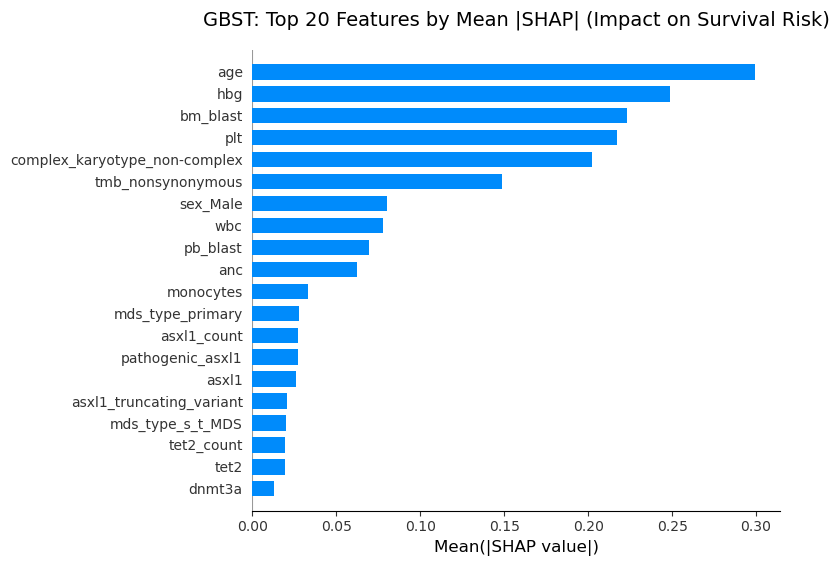

In [28]:
### SHAP Summary Plots - Bar Plot (Feature Importance) - GBST

# SHAP bar plot for GBST 
shap.summary_plot(
    shap_values_gbst.values,
    X_explain_gbst,
    plot_type="bar",
    show=False,
    max_display=20  # top 20 features
)

fig = plt.gcf()
fig.set_size_inches(8, 6)  # control figure size

# Titles & labels
plt.title(
    "GBST: Top 20 Features by Mean |SHAP| (Impact on Survival Risk)",
    fontsize=14,
    pad=18
)
plt.xlabel("Mean(|SHAP value|)", fontsize=12)

# Tidy up fonts and layout
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave room for title

# Save high-res figure
#plt.savefig(FIGURES / "shap_gbst_bar_os.tiff", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/f7/t8zl7d695bbb8mgm4knjm3fh0000gp/T/ipykernel_71204/3427731959.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


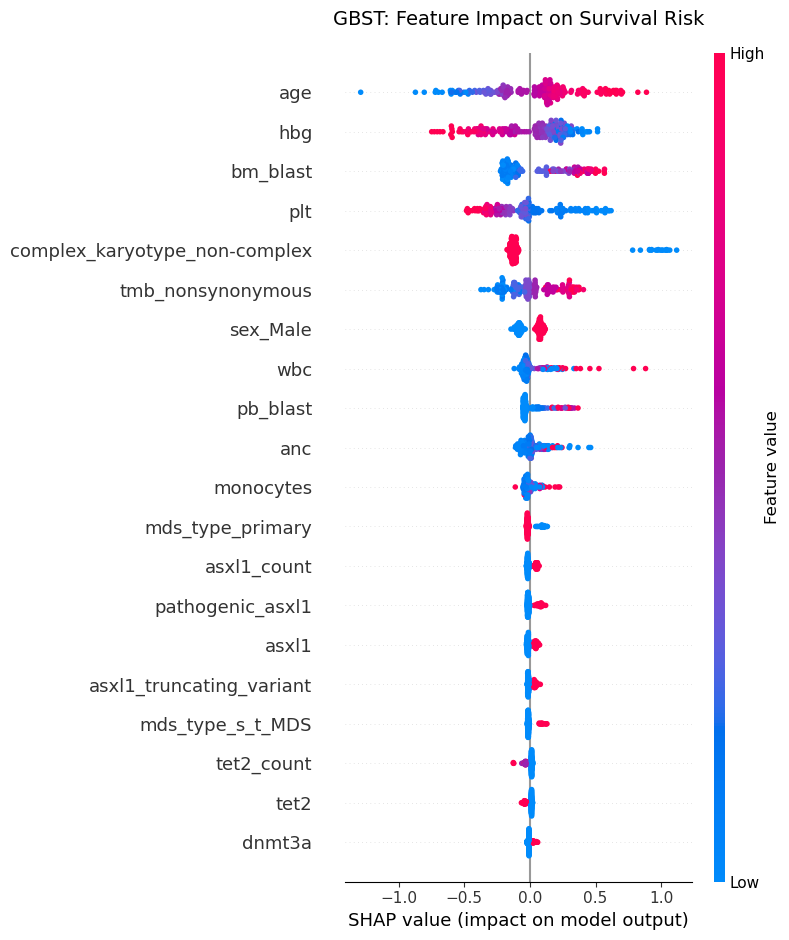


Interpretation:
- Each dot is a patient
- Red = high feature value, Blue = low feature value
- Right side (positive SHAP) = increases risk
- Left side (negative SHAP) = decreases risk


In [29]:
### SHAP Beeswarm Plot (Feature Impact with Direction) - GBST

plt.figure(figsize=(10, 10))
shap.summary_plot(
    shap_values_gbst.values,
    X_explain_gbst,
    show=False,
    max_display=20  # Show top 20 features
)
plt.title("GBST: Feature Impact on Survival Risk", fontsize=14, pad=20)
plt.tight_layout()
#plt.savefig(FIGURES / "shap_gbst_beeswarm_os.tiff", dpi=300, bbox_inches="tight")
plt.show()

print("\nInterpretation:")
print("- Each dot is a patient")
print("- Red = high feature value, Blue = low feature value")
print("- Right side (positive SHAP) = increases risk")
print("- Left side (negative SHAP) = decreases risk")

### SHAP dependence plot ASXL1 versus non ASXL1
To better understand the importance of ASXL1 and non-ASXL1 DTA mutations, we plotted them separately

Missing columns: []


<Figure size 700x500 with 0 Axes>

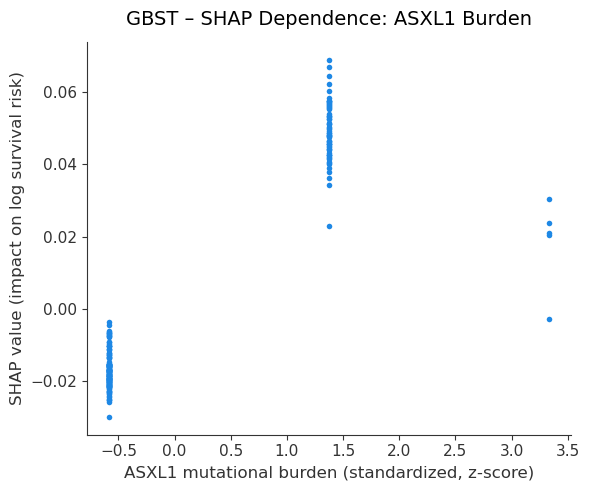

In [30]:
### SHAP Dependence Plot for ASXL1 Burden - GBST

# Ensure 'asxl1_count' is in the DataFrame
needed_cols = ["asxl1_count", "dta_non_asxl1_counts", "asxl1"]
missing = [c for c in needed_cols if c not in X_explain_gbst.columns]
print("Missing columns:", missing)   # should print [] ideally

# For convenience
shap_vals = shap_values_gbst.values  # (n_samples, n_features)


# ASXL1 burden: dependence plot
plt.figure(figsize=(7, 5))
shap.dependence_plot(
    "asxl1_count",
    shap_vals,
    X_explain_gbst,
    interaction_index=None,  # pure main effect
    show=False
)
plt.title("GBST – SHAP Dependence: ASXL1 Burden", fontsize=14, pad=12)
plt.xlabel("ASXL1 mutational burden (standardized, z-score)", fontsize=12)
plt.ylabel("SHAP value (impact on log survival risk)", fontsize=12)
plt.tight_layout()
#plt.savefig(FIGURES / "dep_asxl1_count_os.tiff", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 700x500 with 0 Axes>

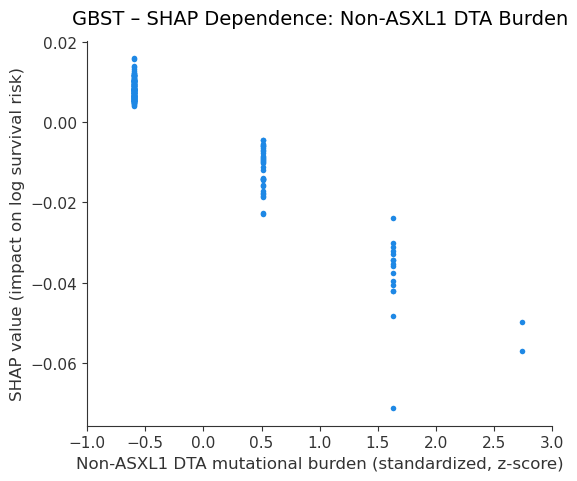

In [31]:
### SHAP Dependence Plot for Non-ASXL1 DTA Burden - GBST

# Ensure 'dta_non_asxl1_counts' is in the DataFrame
plt.figure(figsize=(7, 5))
shap.dependence_plot(
    "dta_non_asxl1_counts",
    shap_vals,
    X_explain_gbst,
    interaction_index=None,
    show=False
)

ax = plt.gca()

# Get current x-limits and create ticks every 0.5
xmin, xmax = ax.get_xlim()
xmin = np.floor(xmin * 2) / 2.0
xmax = np.ceil(xmax * 2) / 2.0
ax.set_xticks(np.arange(xmin, xmax + 0.25, 0.5))

plt.title("GBST – SHAP Dependence: Non-ASXL1 DTA Burden", fontsize=14, pad=12)
plt.xlabel("Non-ASXL1 DTA mutational burden (standardized, z-score)", fontsize=12)
plt.ylabel("SHAP value (impact on log survival risk)", fontsize=12)
#plt.savefig(FIGURES / "dep_dta_non_asxl1_counts_os.tiff", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 700x500 with 0 Axes>

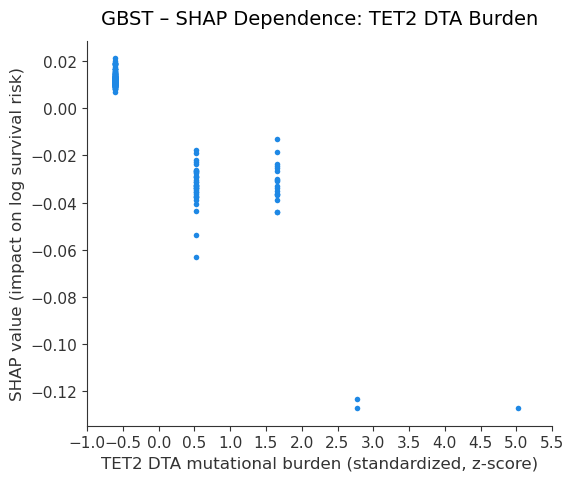

In [32]:
### SHAP Dependence Plot for TET2 DTA Burden - GBST

# Ensure 'tet2_count' is in the DataFrame
plt.figure(figsize=(7, 5))
shap.dependence_plot(
    "tet2_count",
    shap_vals,
    X_explain_gbst,
    interaction_index=None,
    show=False
)

ax = plt.gca()

# Get current x-limits and create ticks every 0.5
xmin, xmax = ax.get_xlim()
xmin = np.floor(xmin * 2) / 2.0
xmax = np.ceil(xmax * 2) / 2.0
ax.set_xticks(np.arange(xmin, xmax + 0.25, 0.5))

plt.title("GBST – SHAP Dependence: TET2 DTA Burden", fontsize=14, pad=12)
plt.xlabel("TET2 DTA mutational burden (standardized, z-score)", fontsize=12)
plt.ylabel("SHAP value (impact on log survival risk)", fontsize=12)
#plt.savefig(FIGURES / "dep_tet2_count_os.tiff", dpi=300, bbox_inches="tight")
plt.show()


### SHAP Analysis for Random Survival Forest (RSF)
Analyzed for comparison with GBST

In [33]:
### Rebuild RSF dataframes in the reduced feature space for SHAP (without refit)
# To avoid the error 'X has 45 features, but RandomSurvivalForest is expecting 37 features as input'


# X_train: original training DataFrame (before VarianceThreshold)
# vt: the VarianceThreshold used for RSF
# X_train_rsf, X_test_rsf: the arrays RSF was actually trained on

if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns
    selected_mask = vt.get_support()
    selected_features = original_feature_names[selected_mask]

    X_train_rsf_df = pd.DataFrame(X_train_rsf, columns=selected_features)
    X_test_rsf_df  = pd.DataFrame(X_test_rsf,  columns=selected_features)
else:
    # Fallback if X_train wasn't a DataFrame
    X_train_rsf_df = pd.DataFrame(X_train_rsf)
    X_test_rsf_df  = pd.DataFrame(X_test_rsf)

In [34]:
### SHAP for RSF Model

# Background sample (for SHAP baseline)
X_bg_rsf = X_train_rsf_df.sample(
    n=min(100, X_train_rsf_df.shape[0]),
    random_state=42)

# Test sample to explain
X_explain_rsf = X_test_rsf_df.sample(
    n=min(200, X_test_rsf_df.shape[0]),
    random_state=42)

print(f"Background sample:  {X_bg_rsf.shape}")
print(f"Explanation sample: {X_explain_rsf.shape}")

# SHAP explainer – RSF risk scores
explainer_rsf = shap.Explainer(
    lambda x: rsf_best.predict(x if isinstance(x, np.ndarray) else x.values),
    X_bg_rsf)

print("Computing SHAP values for RSF... (this may take a few minutes)")
shap_values_rsf = explainer_rsf(X_explain_rsf)

print(f"SHAP values shape: {shap_values_rsf.values.shape}")

Background sample:  (100, 43)
Explanation sample: (200, 43)
Computing SHAP values for RSF... (this may take a few minutes)


PermutationExplainer explainer: 201it [1:40:36, 30.18s/it]                         

SHAP values shape: (200, 43)


/var/folders/f7/t8zl7d695bbb8mgm4knjm3fh0000gp/T/ipykernel_71204/929190433.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


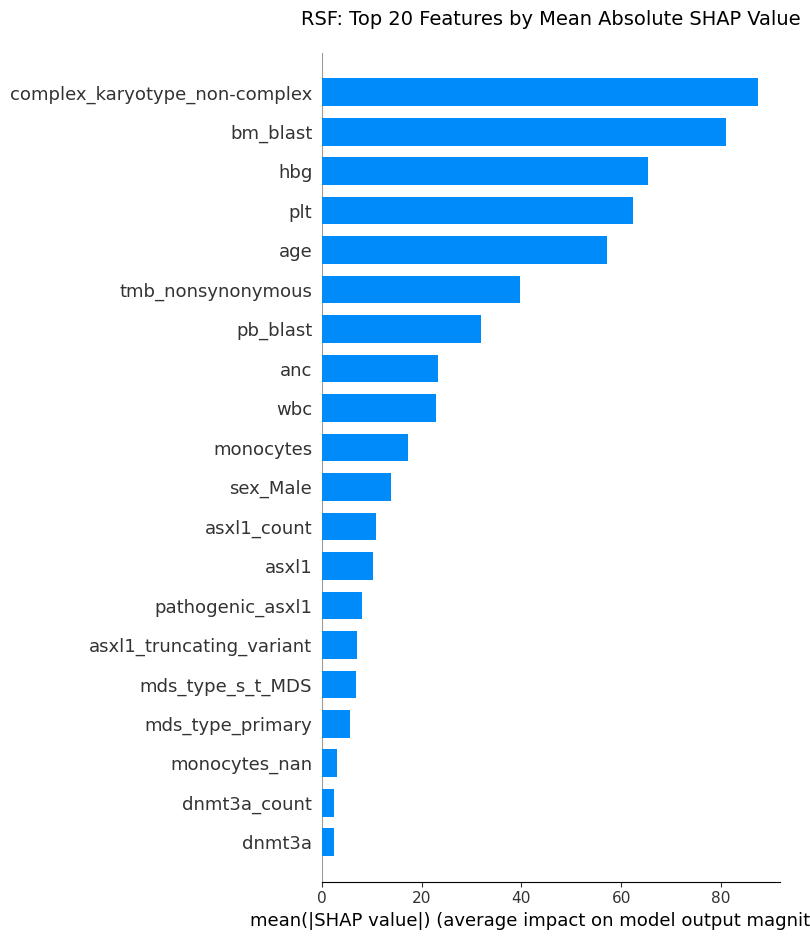

/var/folders/f7/t8zl7d695bbb8mgm4knjm3fh0000gp/T/ipykernel_71204/929190433.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


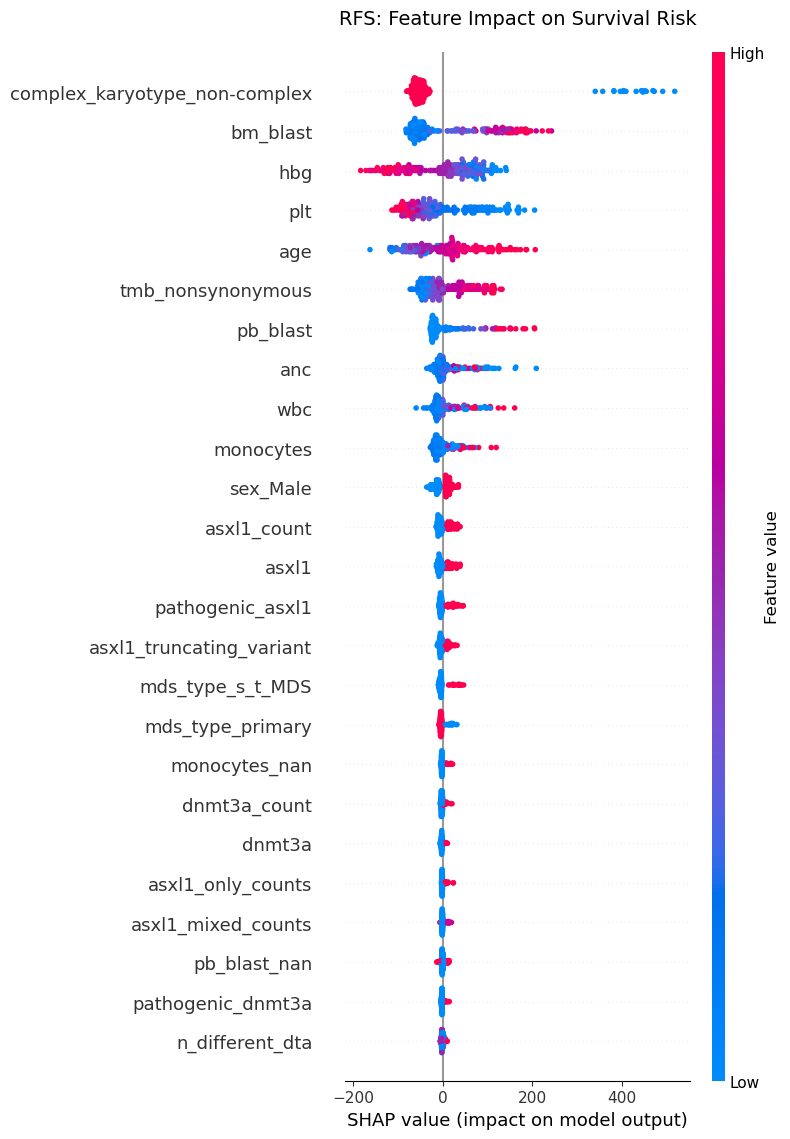

In [35]:
### RSF SHAP Summary Plots

# Bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_rsf.values,
    X_explain_rsf,
    plot_type="bar",
    show=False,
    max_display=20)

plt.title("RSF: Top 20 Features by Mean Absolute SHAP Value", fontsize=14, pad=20)
plt.tight_layout()
#plt.savefig(FIGURES/"shap_rsf_bar_os.tiff", dpi=300, bbox_inches="tight")
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 10))
shap.summary_plot(
    shap_values_rsf.values,
    X_explain_rsf,
    show=False,
    max_display=25)

plt.title("RFS: Feature Impact on Survival Risk", fontsize=14, pad=20)
plt.tight_layout()
#plt.savefig(FIGURES/"shap_rsf_beeswarm_os.tiff", dpi=300, bbox_inches="tight")
plt.show()

## Comparison: GBST and RSF

### Feature Importance Comparison: GBST vs RSF

Compare which features are most important across different models.

Top 20 Features by Average *Normalized* SHAP Importance (GBST + RSF):

                      feature  gbst_importance  rsf_importance  avg_importance
                     bm_blast         0.113326        0.135696        0.124511
                          age         0.146835        0.097225        0.122030
                          hbg         0.128586        0.113433        0.121010
complex_karyotype_non-complex         0.097668        0.136602        0.117135
                          plt         0.108629        0.106285        0.107457
            tmb_nonsynonymous         0.077329        0.070576        0.073952
                     pb_blast         0.033861        0.051758        0.042809
                          wbc         0.036321        0.037843        0.037082
                          anc         0.029467        0.036883        0.033175
                     sex_Male         0.042187        0.023832        0.033009
                    monocytes         0.017084        0.0301

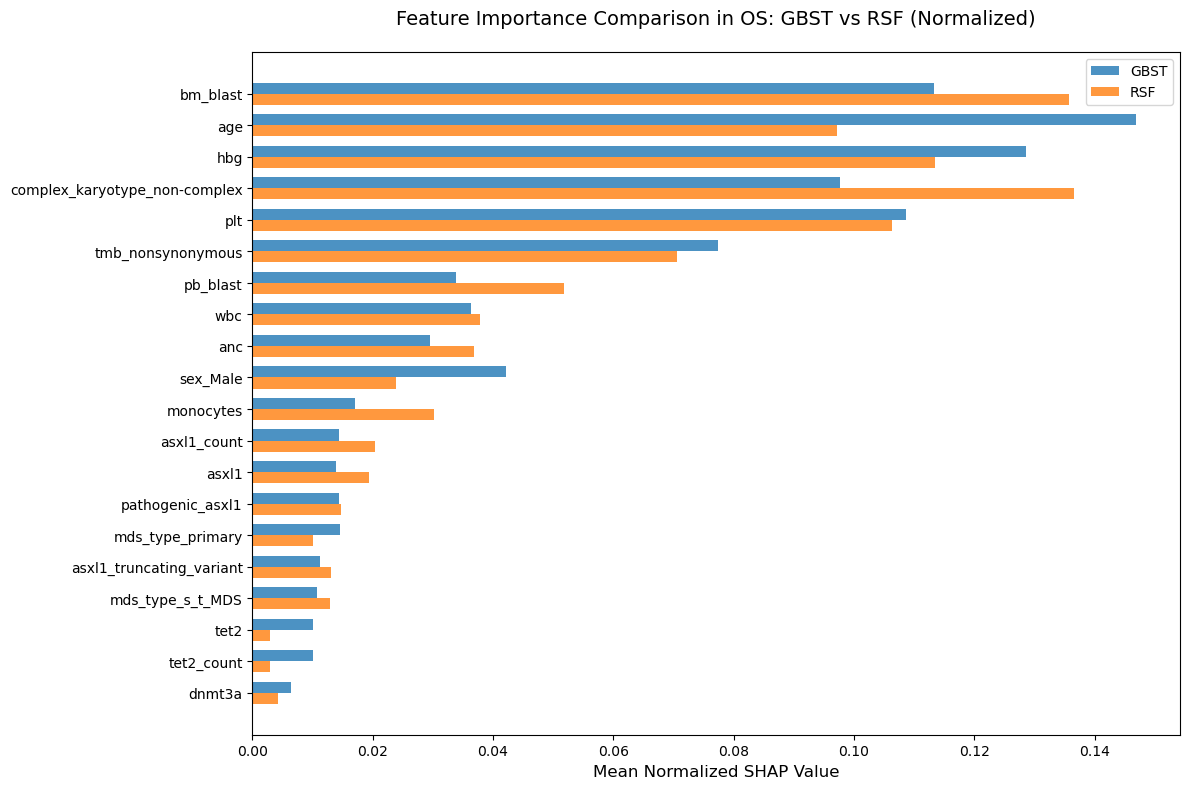

In [36]:
### Compare Feature Importance Across Models (Normalized)


## Normalize SHAP values

# GBST normalized importance
gbst_raw = np.abs(shap_values_gbst.values)
gbst_norm = gbst_raw / gbst_raw.sum(axis=1, keepdims=True)   # normalize per sample
gbst_importance = pd.DataFrame({
    'feature': X_explain_gbst.columns,
    'gbst_importance': gbst_norm.mean(axis=0)
}).sort_values('gbst_importance', ascending=False)

# RSF normalized importance
rsf_raw = np.abs(shap_values_rsf.values)
rsf_norm = rsf_raw / rsf_raw.sum(axis=1, keepdims=True)      # normalize per sample
rsf_importance = pd.DataFrame({
    'feature': X_explain_rsf.columns,
    'rsf_importance': rsf_norm.mean(axis=0)
}).sort_values('rsf_importance', ascending=False)


## Merge and compare
comparison = gbst_importance.merge(rsf_importance, on='feature', how='outer').fillna(0)
comparison['avg_importance'] = (comparison['gbst_importance'] + comparison['rsf_importance']) / 2
comparison = comparison.sort_values('avg_importance', ascending=False)

## Display top 20
print("Top 20 Features by Average *Normalized* SHAP Importance (GBST + RSF):\n")
print(comparison.head(20).to_string(index=False))

## Plot
top20 = comparison.head(20)
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top20))
width = 0.35

ax.barh(x - width/2, top20['gbst_importance'], width, label='GBST', alpha=0.8)
ax.barh(x + width/2, top20['rsf_importance'], width, label='RSF', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Normalized SHAP Value', fontsize=12)
ax.set_title('Feature Importance Comparison in OS: GBST vs RSF (Normalized)', fontsize=14, pad=20)
ax.legend()

plt.tight_layout()
#plt.savefig(FIGURES/"shap_model_comparison_os_normalized.tiff", dpi=300, bbox_inches="tight")
plt.show()


Top 20 Features by Average SHAP Importance (GBST + RSF):

                      feature  gbst_importance  rsf_importance  avg_importance
complex_karyotype_non-complex         0.202299       87.478869       43.840584
                     bm_blast         0.223067       81.091529       40.657298
                          hbg         0.248836       65.444557       32.846697
                          plt         0.216913       62.377923       31.297418
                          age         0.299290       57.206392       28.752841
            tmb_nonsynonymous         0.148785       39.801332       19.975058
                     pb_blast         0.069619       31.931904       16.000761
                          anc         0.062374       23.184615       11.623495
                          wbc         0.077706       22.873195       11.475451
                    monocytes         0.033256       17.258551        8.645904
                     sex_Male         0.079844       13.761523        6.9

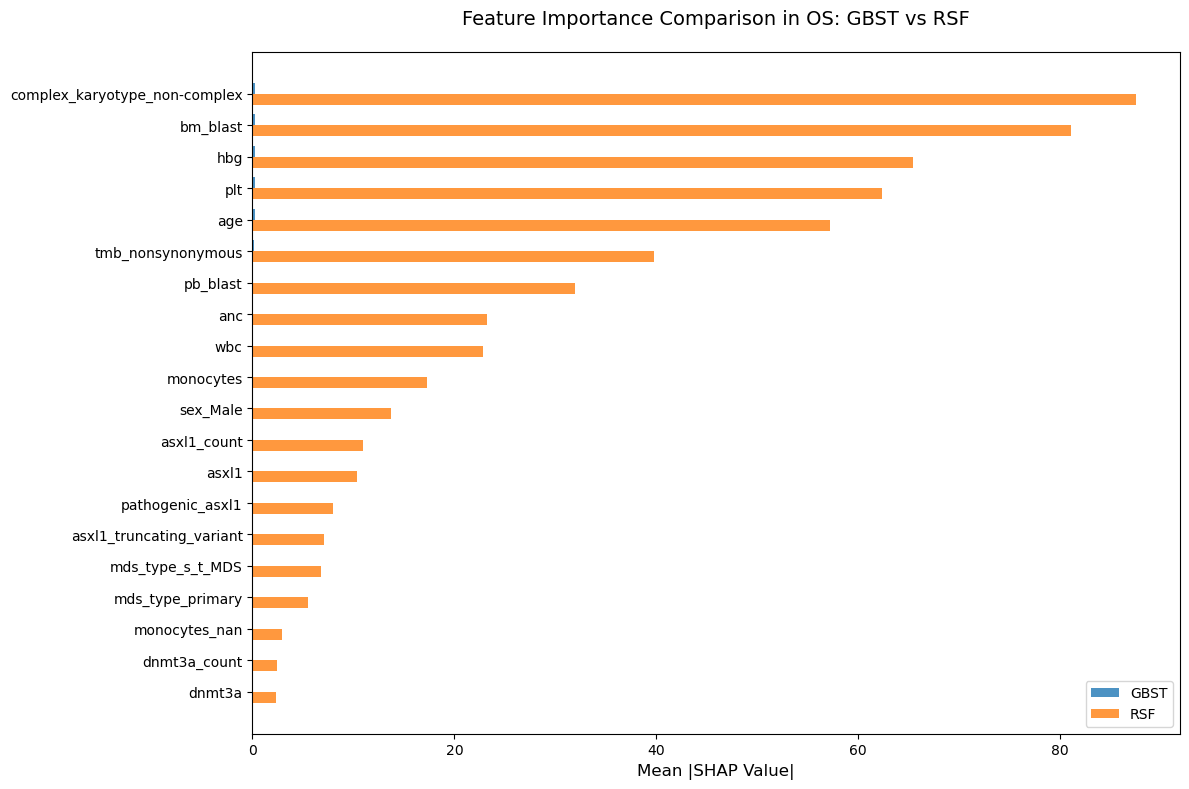

In [37]:
### Compare Feature Importance Across Models

# Calculate mean absolute SHAP values for each model (mean raw values)
gbst_importance = pd.DataFrame({
    'feature': X_explain_gbst.columns,
    'gbst_importance': np.abs(shap_values_gbst.values).mean(axis=0)
}).sort_values('gbst_importance', ascending=False)

rsf_importance = pd.DataFrame({
    'feature': X_explain_rsf.columns,
    'rsf_importance': np.abs(shap_values_rsf.values).mean(axis=0)
}).sort_values('rsf_importance', ascending=False)

# Merge and compare
comparison = gbst_importance.merge(rsf_importance, on='feature')
comparison['avg_importance'] = (comparison['gbst_importance'] + comparison['rsf_importance']) / 2
comparison = comparison.sort_values('avg_importance', ascending=False)

# Display top 20 features
print("Top 20 Features by Average SHAP Importance (GBST + RSF):\n")
print(comparison.head(20).to_string(index=False))

# Visualize comparison
top20 = comparison.head(20)
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top20))
width = 0.35

ax.barh(x - width/2, top20['gbst_importance'], width, label='GBST', alpha=0.8)
ax.barh(x + width/2, top20['rsf_importance'], width, label='RSF', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance Comparison in OS: GBST vs RSF', fontsize=14, pad=20)
ax.legend()

plt.tight_layout()
#plt.savefig(FIGURES/"shap_model_comparison_os.tiff", dpi=300, bbox_inches="tight")
plt.show()


### Waterfall plot

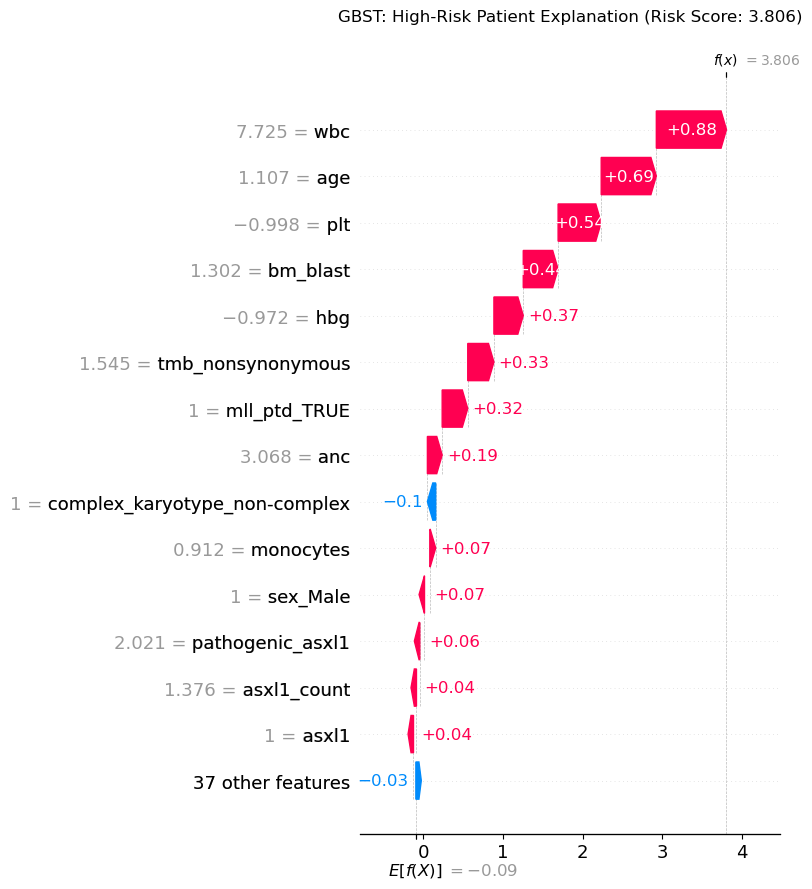

In [38]:
### SHAP Waterfall Plot - High Risk Patient (GBST)

# Find a high-risk patient (high predicted risk score)
gbst_risks = gbst_best.predict(X_explain_gbst.values)
high_risk_idx = np.argmax(gbst_risks)


# Define custom font size
CUSTOM_FONTSIZE = 10

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_values_gbst[high_risk_idx], max_display=15, show=False)

# Access the current axes and iterate through ALL text objects to set font size
ax = plt.gca()

# For feature names, values, SHAP values, etc.
for text in ax.texts:
    text.set_fontsize(CUSTOM_FONTSIZE)

# For x and y tick labels (might be needed if ax.texts doesn't cover them)
ax.tick_params(axis='x', labelsize=CUSTOM_FONTSIZE)
ax.tick_params(axis='y', labelsize=CUSTOM_FONTSIZE * 0.9) # Slightly smaller for long feature names

# For x and y axis labels
ax.set_xlabel(ax.get_xlabel(), fontsize=CUSTOM_FONTSIZE)
ax.set_ylabel(ax.get_ylabel(), fontsize=CUSTOM_FONTSIZE)

# Set the title with desired font size and padding
plt.title(f"GBST: High-Risk Patient Explanation (Risk Score: {gbst_risks[high_risk_idx]:.3f})", 
          fontsize=CUSTOM_FONTSIZE + 2, 
          pad=40) # Increase padding

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
#plt.savefig(OUTPUT/"shap_waterfall_high_risk_gbst_os.tiff", dpi=300, bbox_inches="tight")
plt.show()

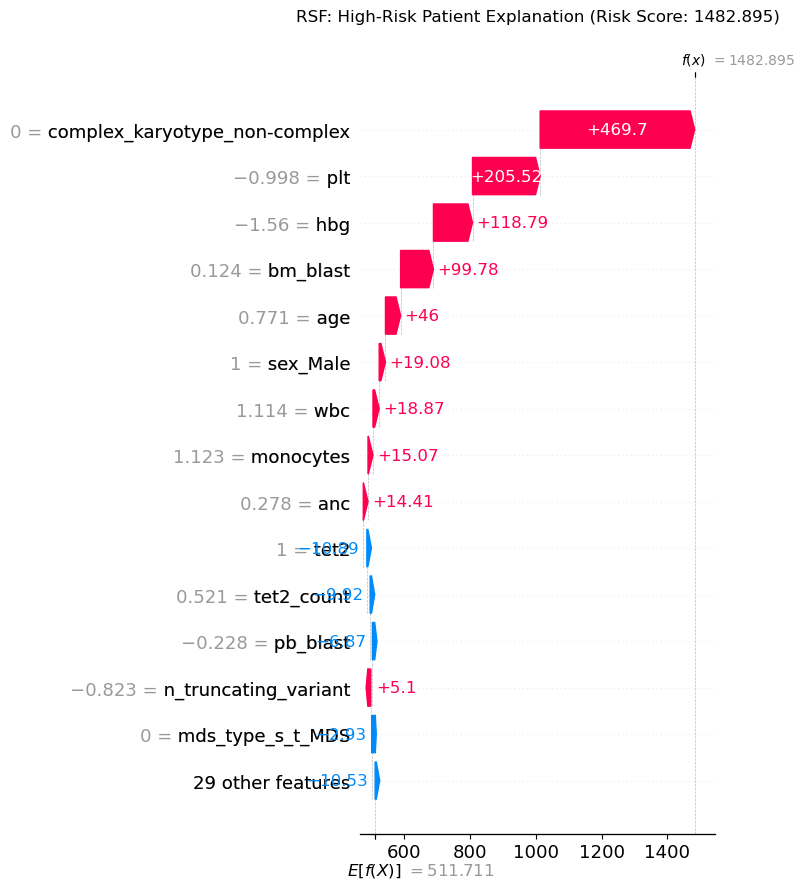

In [39]:
### SHAP Waterfall Plot - High Risk Patient (RSF)

# Find a high-risk patient (high predicted risk score)
rsf_risks = rsf_best.predict(X_explain_rsf.values)
high_risk_idx = np.argmax(rsf_risks)


# Define custom font size
CUSTOM_FONTSIZE = 10

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_values_rsf[high_risk_idx], max_display=15, show=False)

#  Access the current axes and iterate through ALL text objects to set font size
ax = plt.gca()

# For feature names, values, SHAP values, etc.
for text in ax.texts:
    text.set_fontsize(CUSTOM_FONTSIZE)

# For x and y tick labels (might be needed if ax.texts doesn't cover them)
ax.tick_params(axis='x', labelsize=CUSTOM_FONTSIZE)
ax.tick_params(axis='y', labelsize=CUSTOM_FONTSIZE * 0.9) # Slightly smaller for long feature names

# For x and y axis labels
ax.set_xlabel(ax.get_xlabel(), fontsize=CUSTOM_FONTSIZE)
ax.set_ylabel(ax.get_ylabel(), fontsize=CUSTOM_FONTSIZE)

# Set the title with desired font size and padding
plt.title(f"RSF: High-Risk Patient Explanation (Risk Score: {rsf_risks[high_risk_idx]:.3f})", 
          fontsize=CUSTOM_FONTSIZE + 2, 
          pad=40) # Increase padding

plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
#plt.savefig(FIGUREs/"shap_waterfall_high_risk_rsf_os.tiff", dpi=300, bbox_inches="tight")
plt.show()

### Export SHAP Values for Further Analysis

In [40]:
### Export SHAP Values and Feature Importance

# Export GBST SHAP values
shap_df_gbst = pd.DataFrame(
    shap_values_gbst.values,
    columns=X_explain_gbst.columns,
    index=X_explain_gbst.index)

#shap_df_gbst.to_csv(OUTPUT/"shap_values_gbst_os.csv")

# Export RSF SHAP values
shap_df_rsf = pd.DataFrame(
    shap_values_rsf.values,
    columns=X_explain_rsf.columns,
    index=X_explain_rsf.index)

#shap_df_rsf.to_csv(OUTPUT/"shap_values_rsf_os.csv")

# Export feature importance comparison
#comparison.to_csv(OUTPUT/"shap_feature_importance_comparison_os.csv", index=False)


# END